---
# Capstone Scratchpad - Adam Talbot
---

---
## Imports
---

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from datetime import datetime

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# plt.rc('figure', figsize=(13, 7))
# plt.rc('axes.spines', top=False, right=False)
# plt.rc('font', size=13)

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
sns.set_palette('tab20')
# pal = sns.set_palette('tab20')

---
## Acquire
---

In [30]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L1.xlsx')

In [31]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [32]:
df.head()

Year  Period   Area         Ownership  Industry Code  \
0  2017       1  Texas  Local Government           1011   
1  2017       1  Texas           Private           1011   
2  2017       1  Texas         Total All           1011   
3  2017       2  Texas           Private           1011   
4  2017       2  Texas         Total All           1011   

                       Industry  Level  Establishments  Firms  \
0  Natural Resources and Mining      1               3      3   
1  Natural Resources and Mining      1           19547  17486   
2  Natural Resources and Mining      1           19550  17489   
3  Natural Resources and Mining      1           19522  17454   
4  Natural Resources and Mining      1           19524  17456   

   Average Employment  Average Weekly Wage  Total Wages  Month 1 Employment  \
0                   6                  659        51409                   6   
1              269033                 2562   8959344530              266172   
2              269039                 2562   8959395939              266178   
3              278215                 1879   6796444215              274576   
4              278219                 1879   6796485889              274580   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0                   6                   6                      8   
1              269297              271629                      8   
2              269303              271635                      8   
3              278259              281810                      8   
4              278263              281814                      8   

   Total Employment  
0                18  
1            807098  
2            807116  
3            834645  
4            834657

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year                   817 non-null    int64 
 1   Period                 817 non-null    int64 
 2   Area                   817 non-null    object
 3   Ownership              817 non-null    object
 4   Industry Code          817 non-null    int64 
 5   Industry               817 non-null    object
 6   Level                  817 non-null    int64 
 7   Establishments         817 non-null    int64 
 8   Firms                  817 non-null    int64 
 9   Average Employment     817 non-null    int64 
 10  Average Weekly Wage    817 non-null    int64 
 11  Total Wages            817 non-null    int64 
 12  Month 1 Employment     817 non-null    int64 
 13  Month 2 Employment     817 non-null    int64 
 14  Month 3 Employment     817 non-null    int64 
 15  Hierarchical Ordering  

---
## Prepare
---

In [34]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [35]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [36]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

In [37]:
# add a column named quarter and compare to period to see if this workedd
df['Q'] = df.Date.dt.quarter
(df.Q == df.Period).mean()

1.0

In [38]:
df.head()

Year  Period   Area         Ownership  Industry Code  \
0  2017       1  Texas  Local Government           1011   
1  2017       1  Texas           Private           1011   
2  2017       1  Texas         Total All           1011   
3  2017       2  Texas           Private           1011   
4  2017       2  Texas         Total All           1011   

                       Industry  Level  Establishments  Firms  \
0  Natural Resources and Mining      1               3      3   
1  Natural Resources and Mining      1           19547  17486   
2  Natural Resources and Mining      1           19550  17489   
3  Natural Resources and Mining      1           19522  17454   
4  Natural Resources and Mining      1           19524  17456   

   Average Employment  ...  Total Wages  Month 1 Employment  \
0                   6  ...        51409                   6   
1              269033  ...   8959344530              266172   
2              269039  ...   8959395939              266178   
3              278215  ...   6796444215              274576   
4              278219  ...   6796485889              274580   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0                   6                   6                      8   
1              269297              271629                      8   
2              269303              271635                      8   
3              278259              281810                      8   
4              278263              281814                      8   

   Total Employment  First Month Quarter       Date  Q  
0                18            1  2017-1 2017-01-01  1  
1            807098            1  2017-1 2017-01-01  1  
2            807116            1  2017-1 2017-01-01  1  
3            834645            4  2017-4 2017-04-01  2  
4            834657            4  2017-4 2017-04-01  2  

[5 rows x 21 columns]

---
## Exploration
---

### Level 1 Industries

---
#### One ownership category and a few industries

In [120]:
# create new df with just totals
total_df = df[df.Ownership == 'Total All']

In [121]:
# take a look at all industries represented
ind_list = total_df.Industry.value_counts().index.tolist()
# ind_list

In [122]:
# # try for a few industries
# nrm_t = total_df[total_df.Industry == 'Natural Resources and Mining']
# ttu_t = total_df[total_df.Industry == 'Trade, Transportation and Utilities']

In [123]:
# # try to plot total wages over time
# nrm_t[['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label='Natural Resources and Mining')
# ttu_t[['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label='Trade, Transportation and Utilities')
# plt.gca().set(ylabel = 'Total Wages ($)', title='Level 1 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}B'.format(x / 1_000_000_000))
# plt.legend(bbox_to_anchor= (1.03,1));

In [124]:
# # try to plot total wages over time
# nrm_t[['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label='Natural Resources and Mining')
# ttu_t[['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label='Trade, Transportation and Utilities')
# plt.gca().set(ylabel = 'Total Employment', title='Natural Resources and Mining')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
#### One ownership category and all industries

In [125]:
# loop through list of industries and add to dict of dfs with key being industry name
df_dict = {}
for ind in ind_list:
    df_dict[ind] = total_df[total_df.Industry == ind]

In [127]:
# # loop through dictionary to plot all dfs on same plot
# for ind in ind_list:
#     df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
# plt.gca().set(ylabel = 'Total Wages ($)', title='Level 1 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}B'.format(x / 1_000_000_000))
# plt.legend(bbox_to_anchor= (1.03,1));

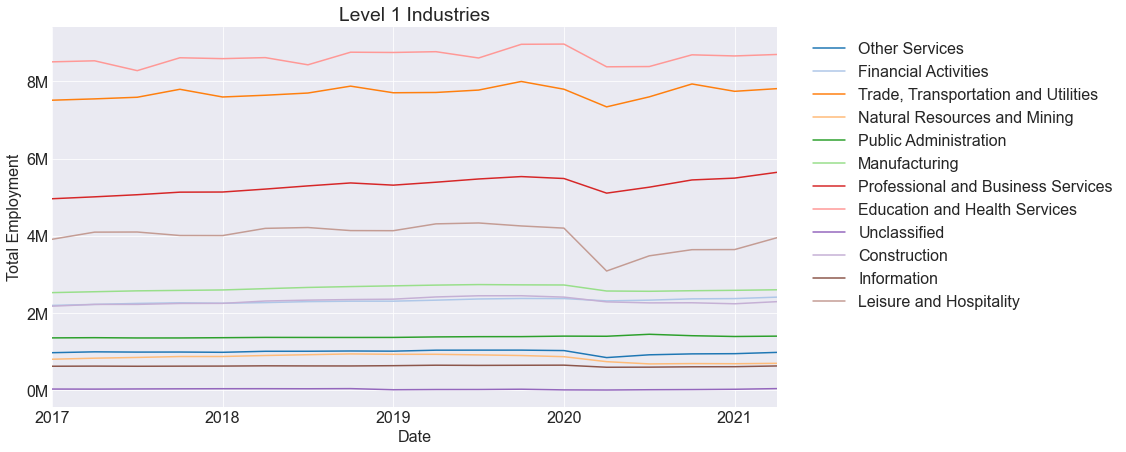

In [128]:
# do the same thing for wages
for ind in ind_list:
    df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 1 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1));

---
#### All ownership categories and all industries

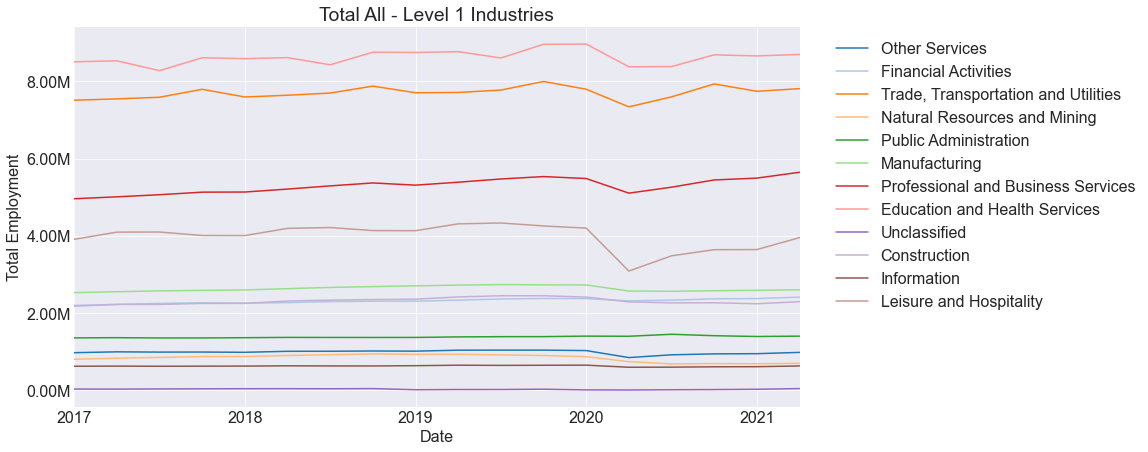

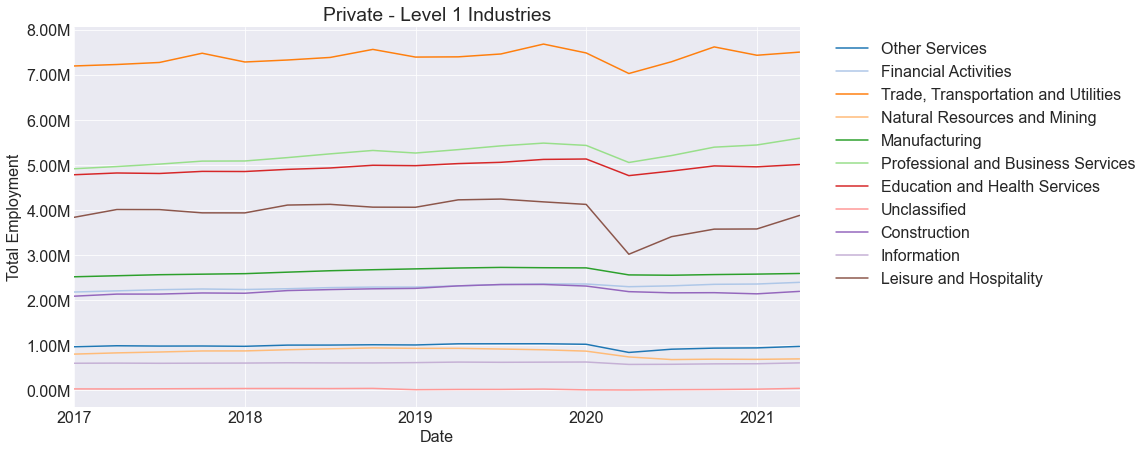

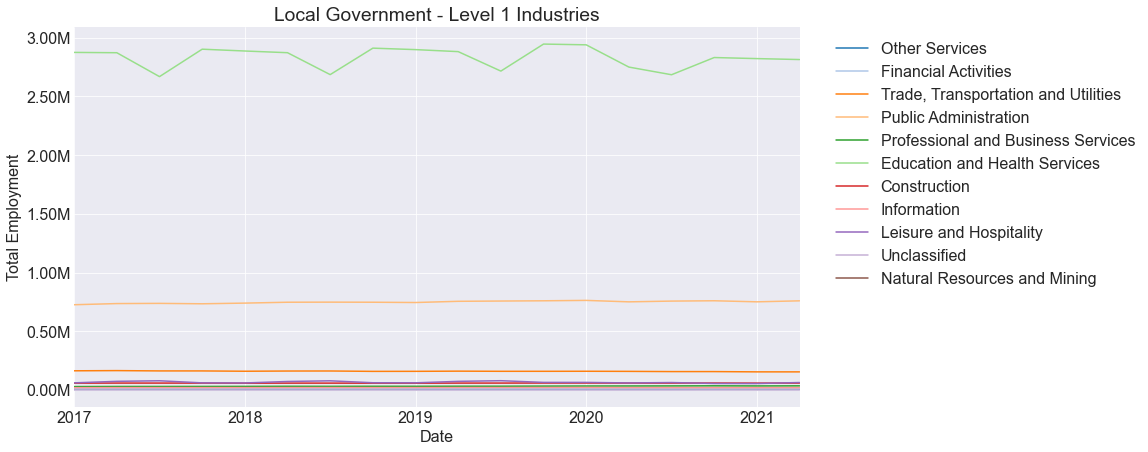

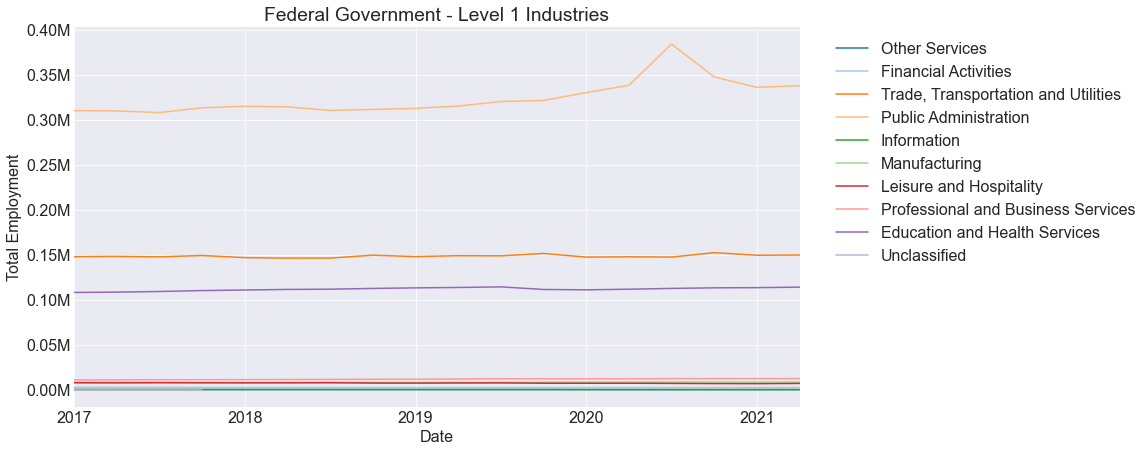

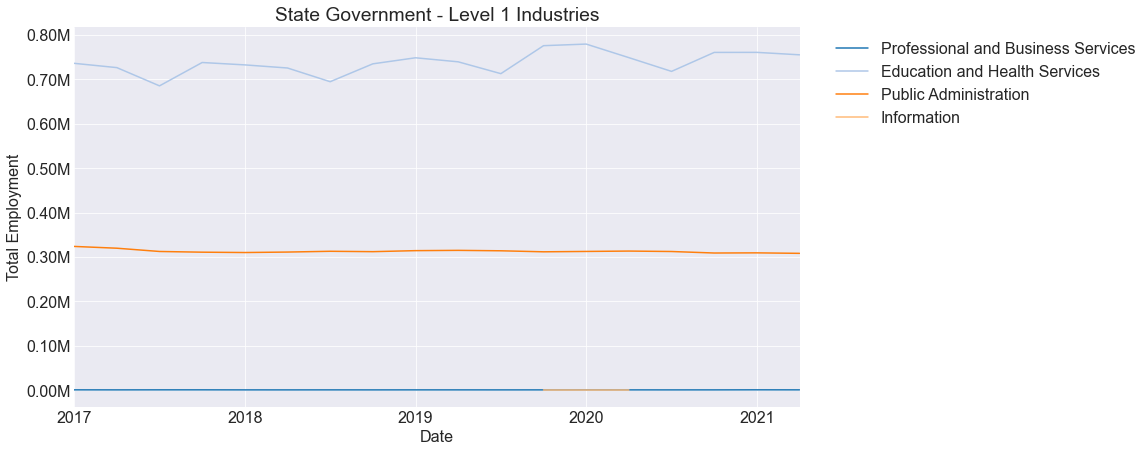

In [129]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 1 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 1 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

---
### Level 2 Industries
---

In [130]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L2.xlsx')

In [131]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [133]:
df.head()

Year  Period   Area  Ownership Industry Code  \
0  2017       1  Texas    Private            11   
1  2017       1  Texas  Total All            11   
2  2017       2  Texas    Private            11   
3  2017       2  Texas  Total All            11   
4  2017       3  Texas    Private            11   

                                     Industry  Level  Establishments  Firms  \
0  Agriculture, Forestry, Fishing and Hunting      2           10181   9992   
1  Agriculture, Forestry, Fishing and Hunting      2           10183   9994   
2  Agriculture, Forestry, Fishing and Hunting      2           10195  10005   
3  Agriculture, Forestry, Fishing and Hunting      2           10196  10006   
4  Agriculture, Forestry, Fishing and Hunting      2           10233  10046   

   Average Employment  Average Weekly Wage  Total Wages  Month 1 Employment  \
0               59382                  678    523308575               59862   
1               59385                  678    523329361               59865   
2               59688                  659    511656748               59346   
3               59689                  659    511662656               59347   
4               59478                  676    522814838               59186   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0               58939               59346                      9   
1               58942               59349                      9   
2               59635               60083                      9   
3               59636               60084                      9   
4               59716               59531                      9   

   Total Employment  
0            178147  
1            178156  
2            179064  
3            179067  
4            178433

In [134]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [135]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [136]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

---
#### All ownership categories and all industries

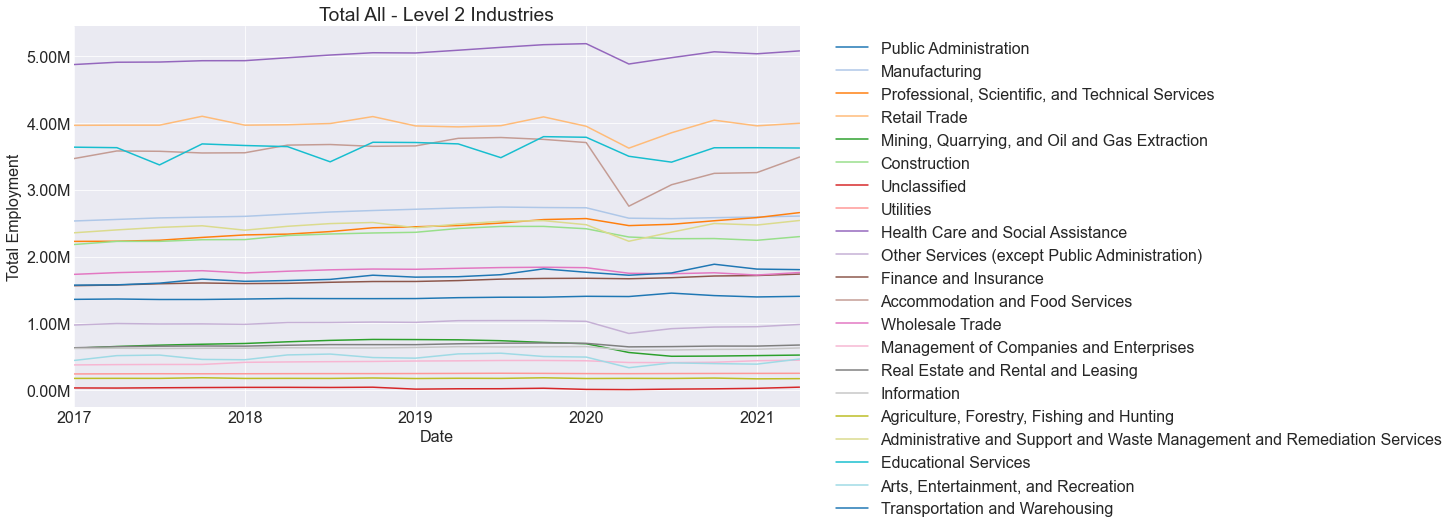

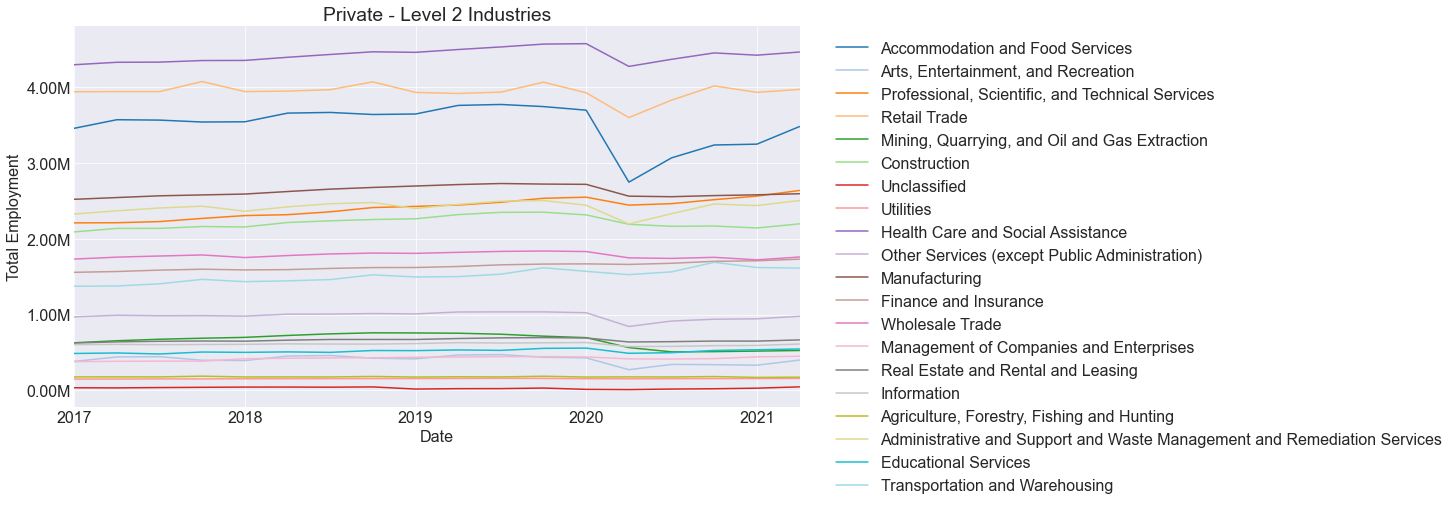

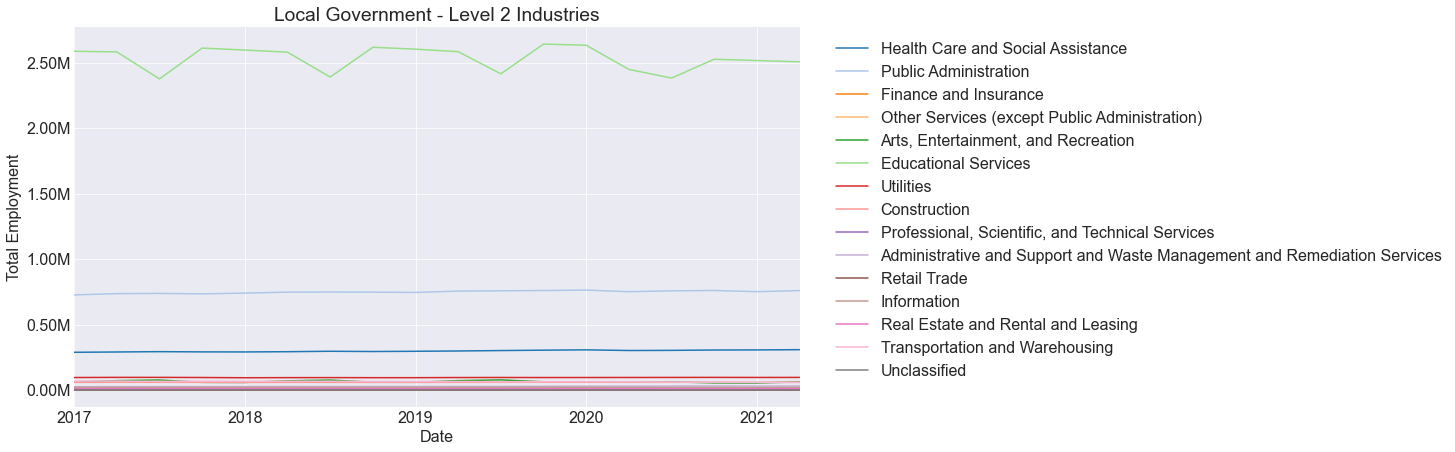

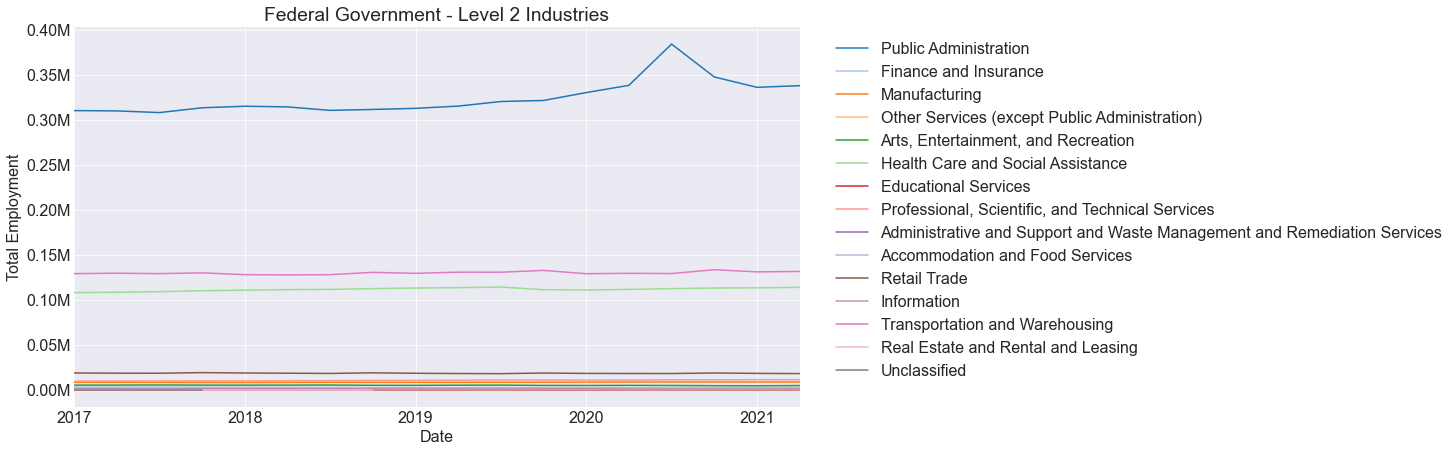

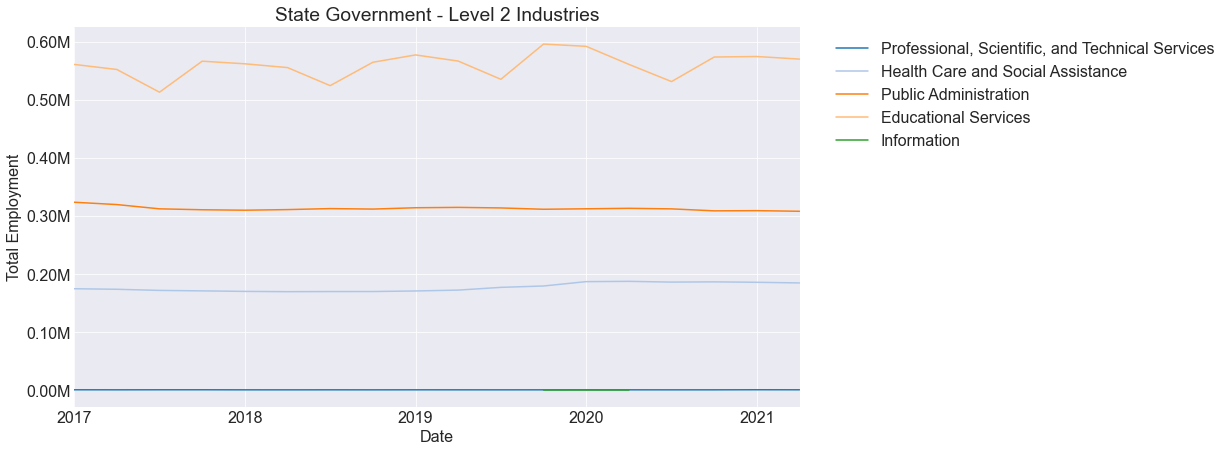

In [137]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 2 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 2 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

---
### Level 3 Industries
---

In [197]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L3.xlsx')

In [198]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [199]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [200]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [201]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

---
#### All ownership categories and all industries

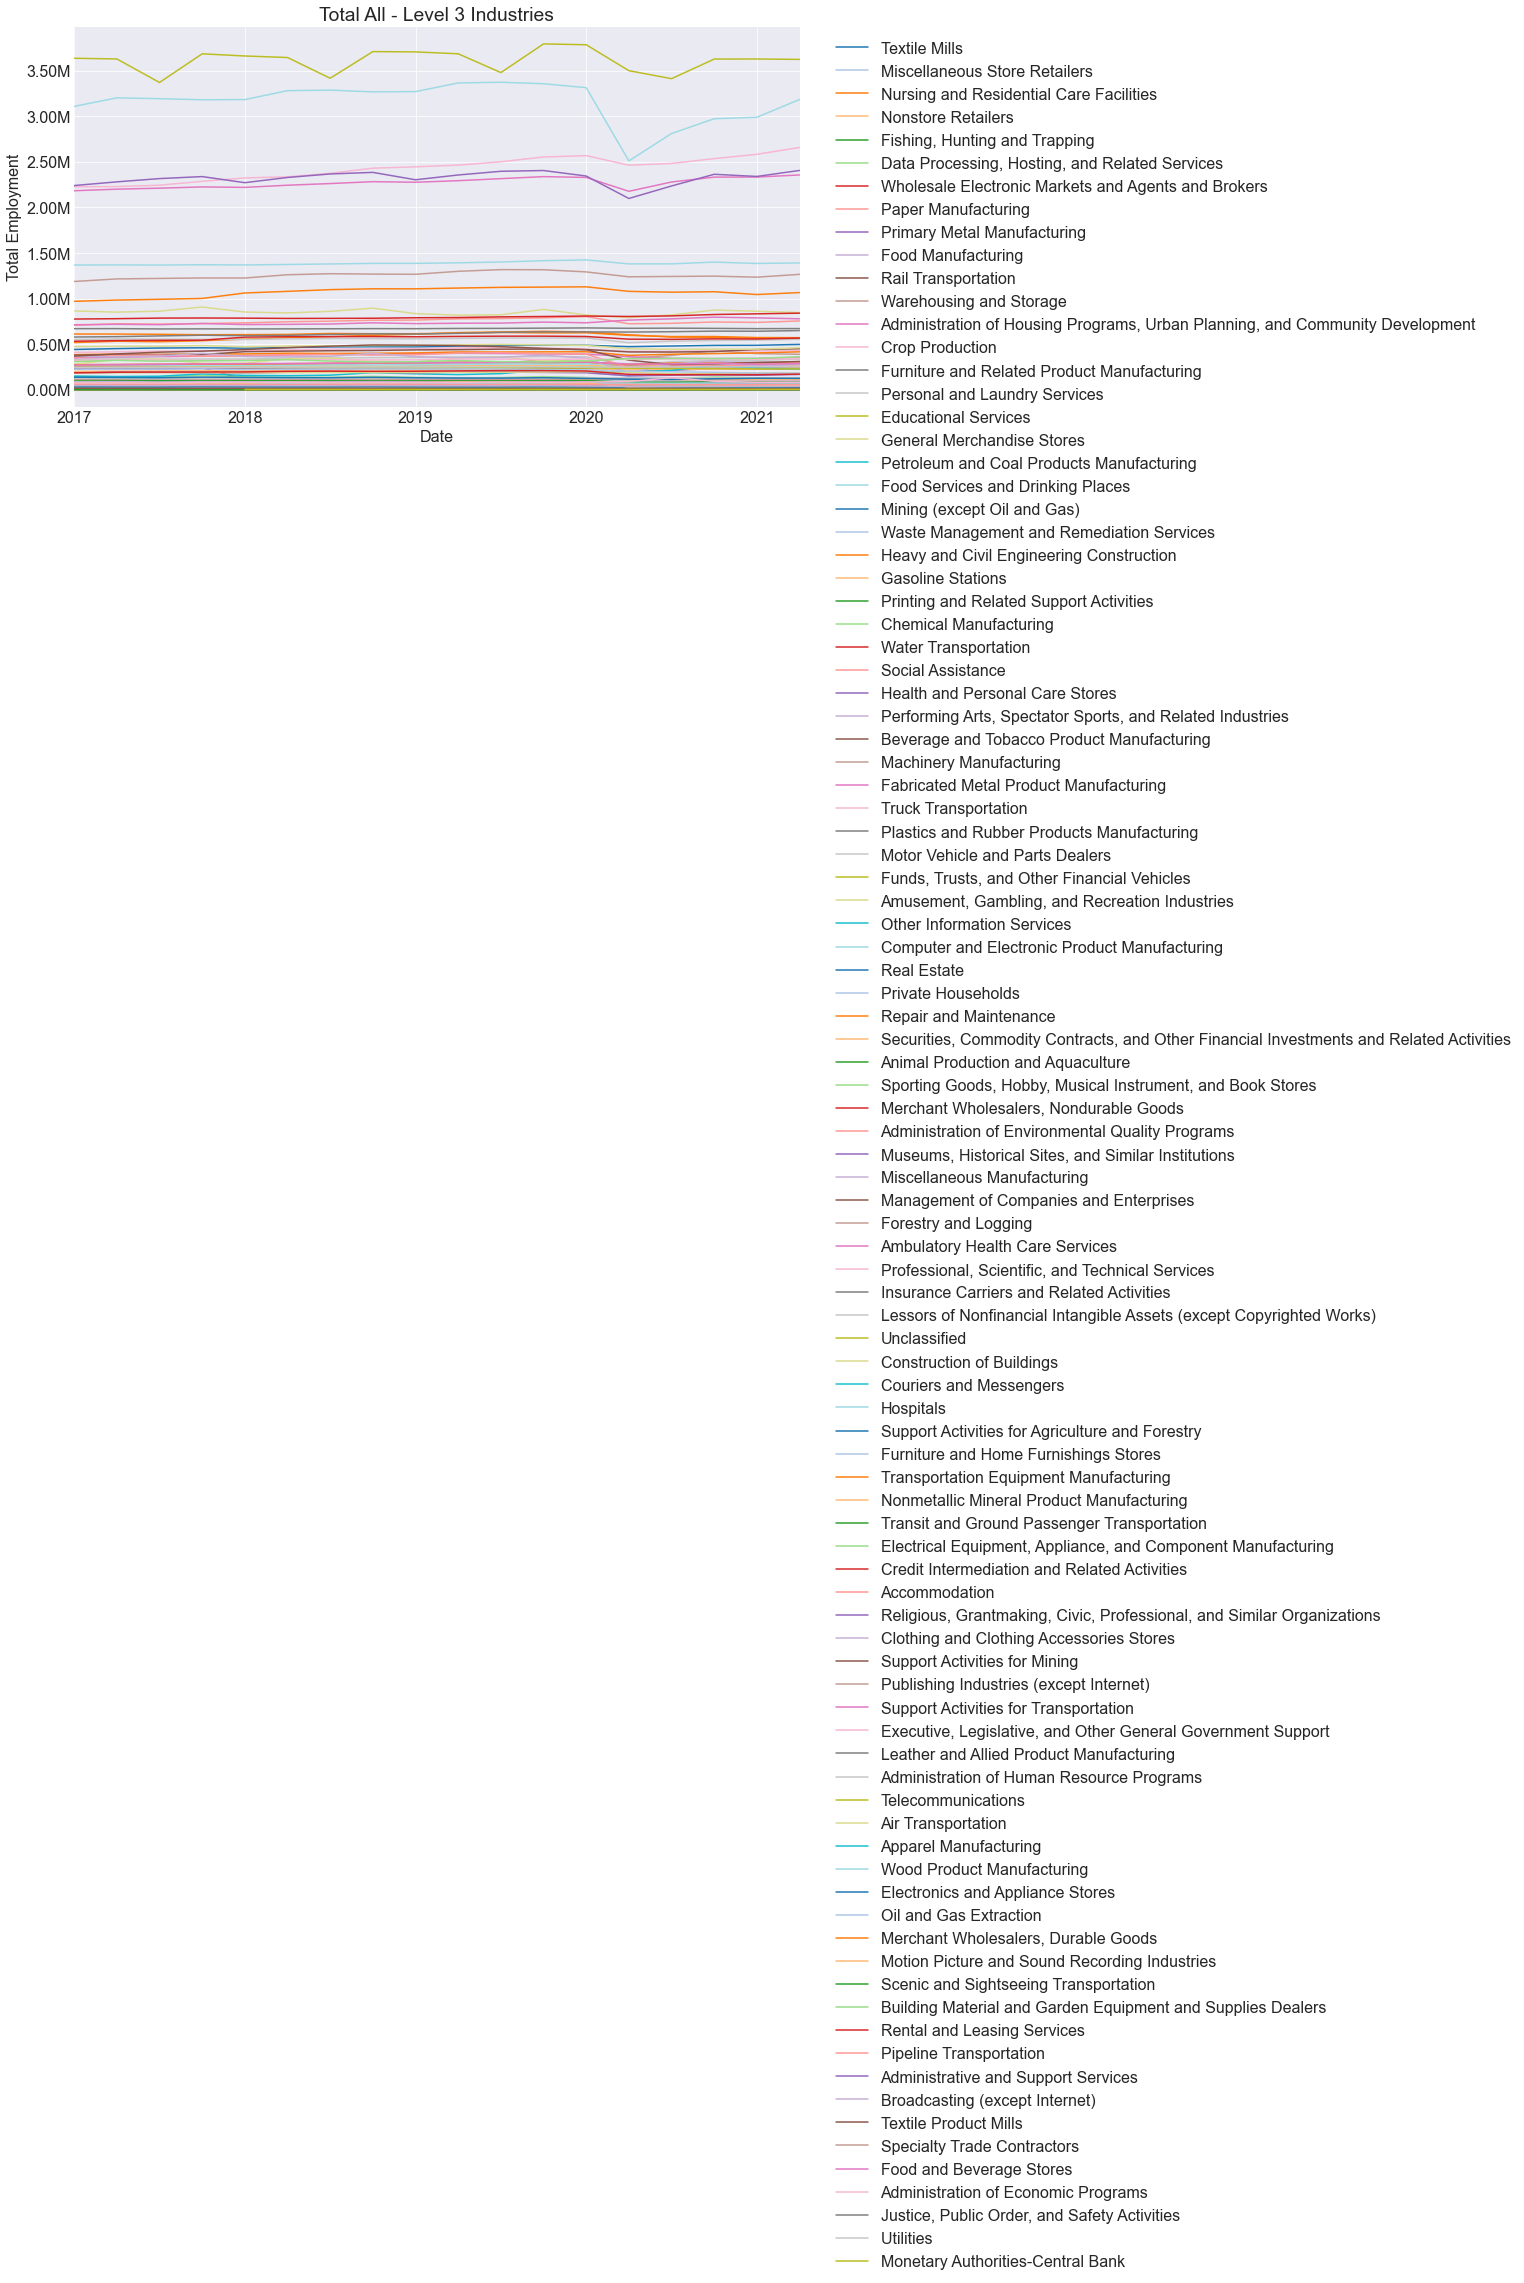

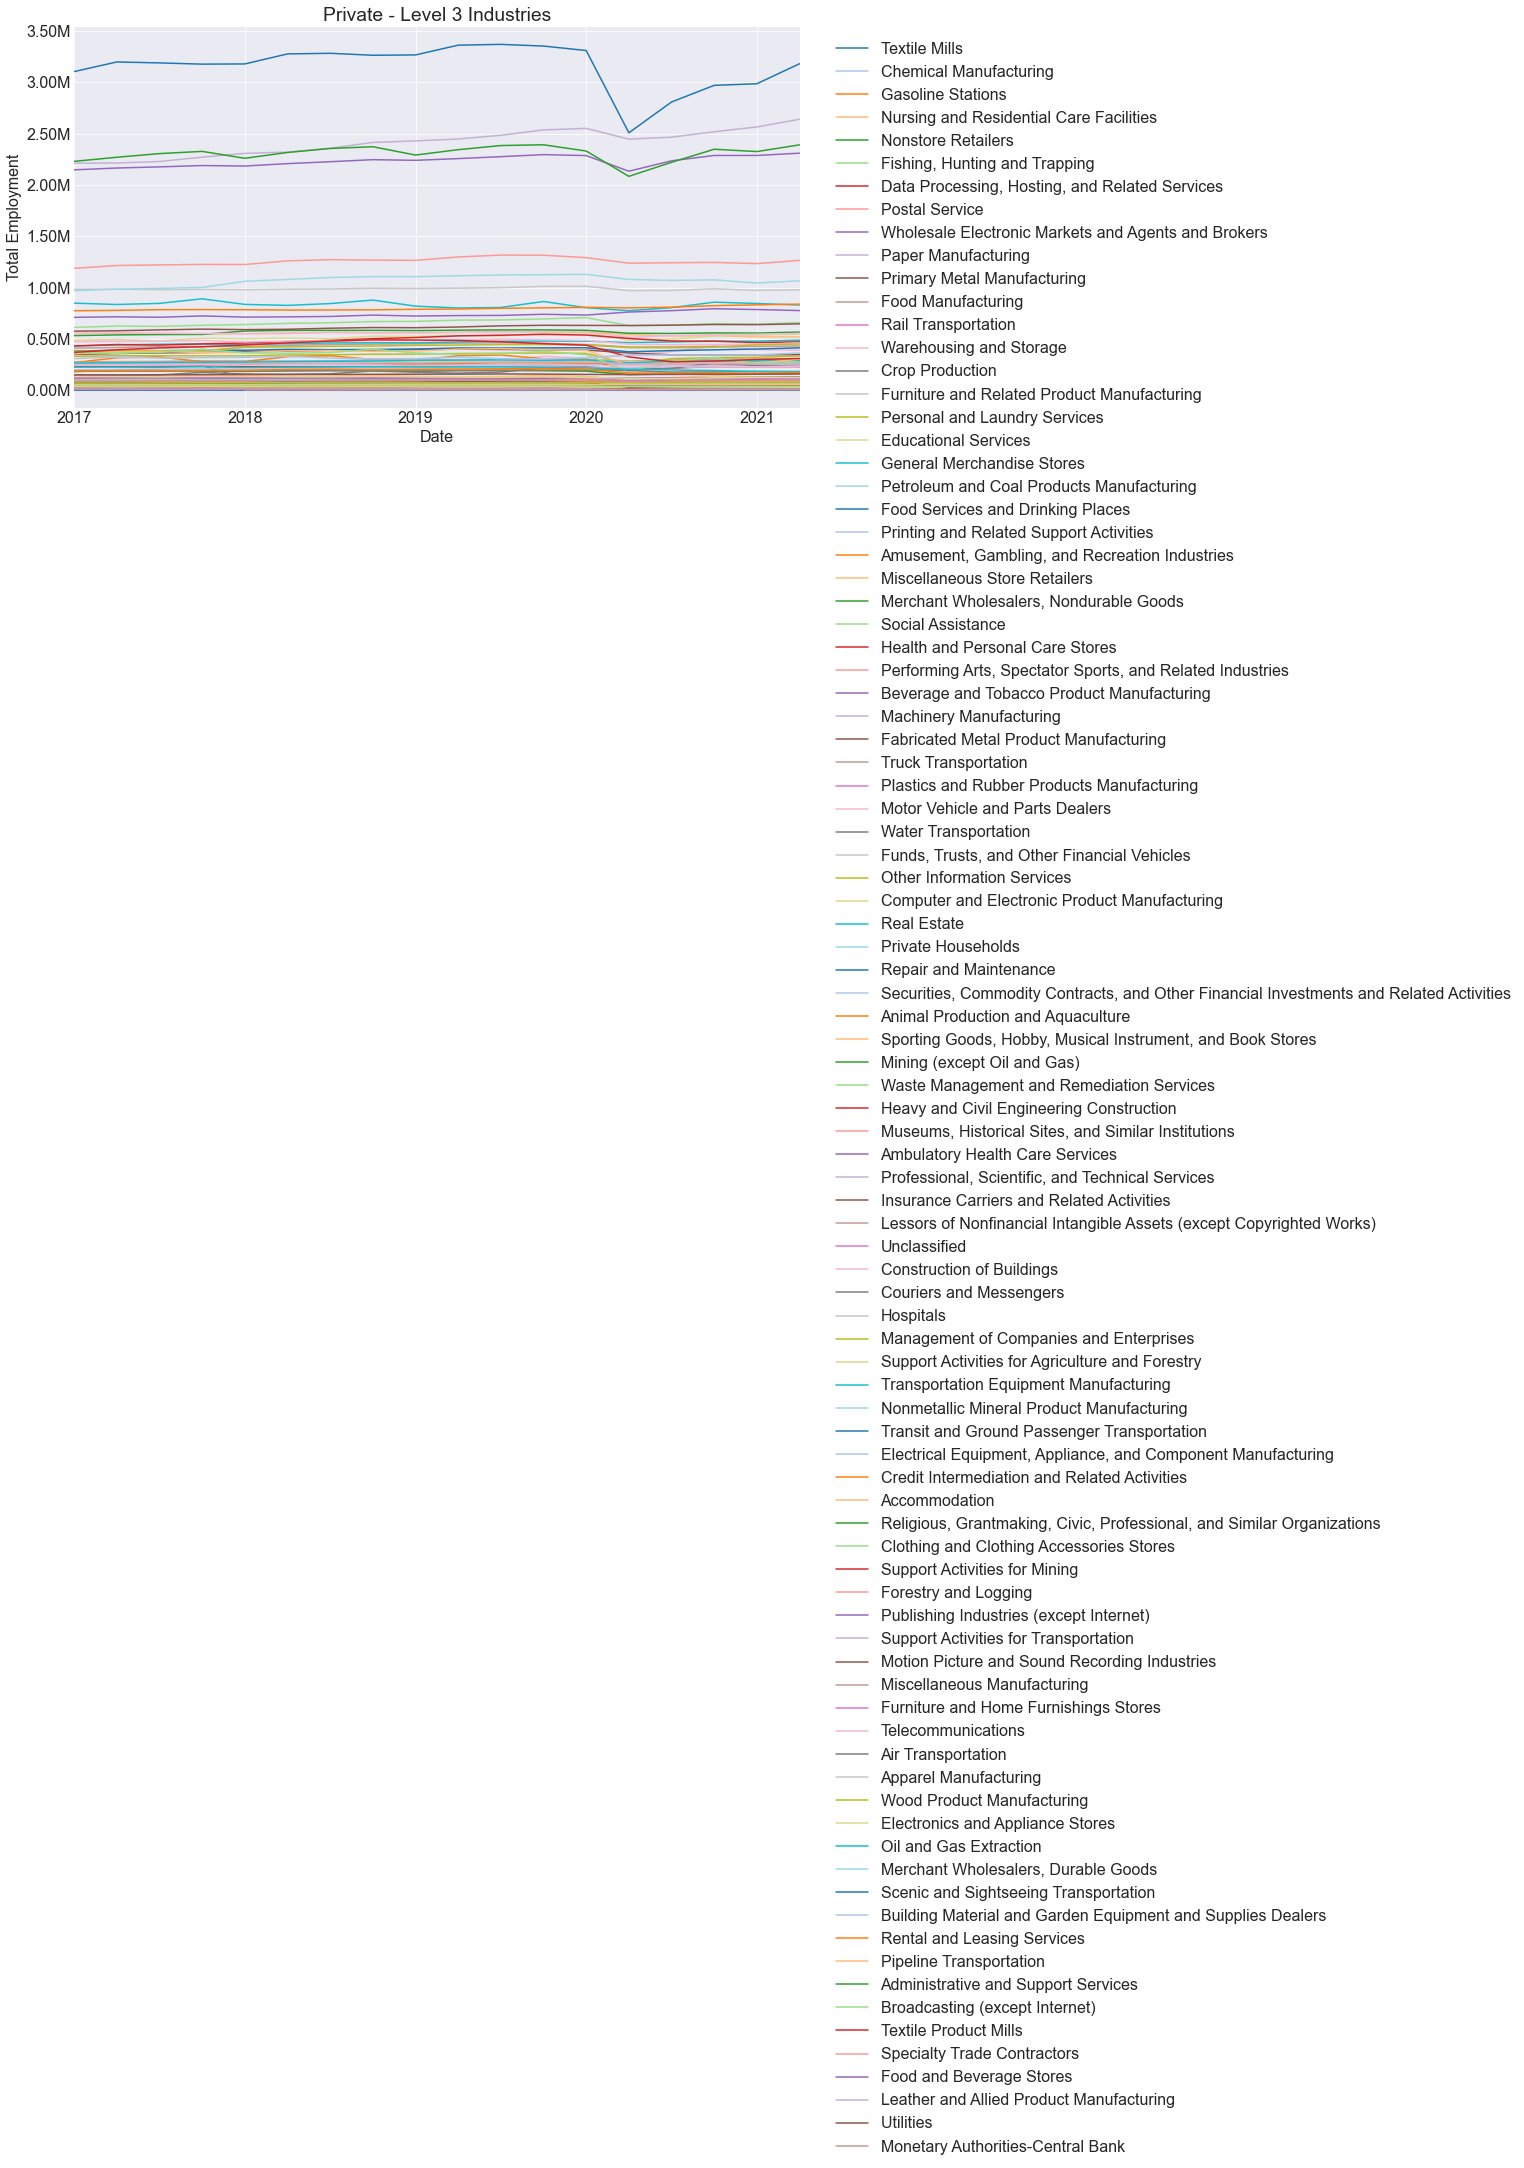

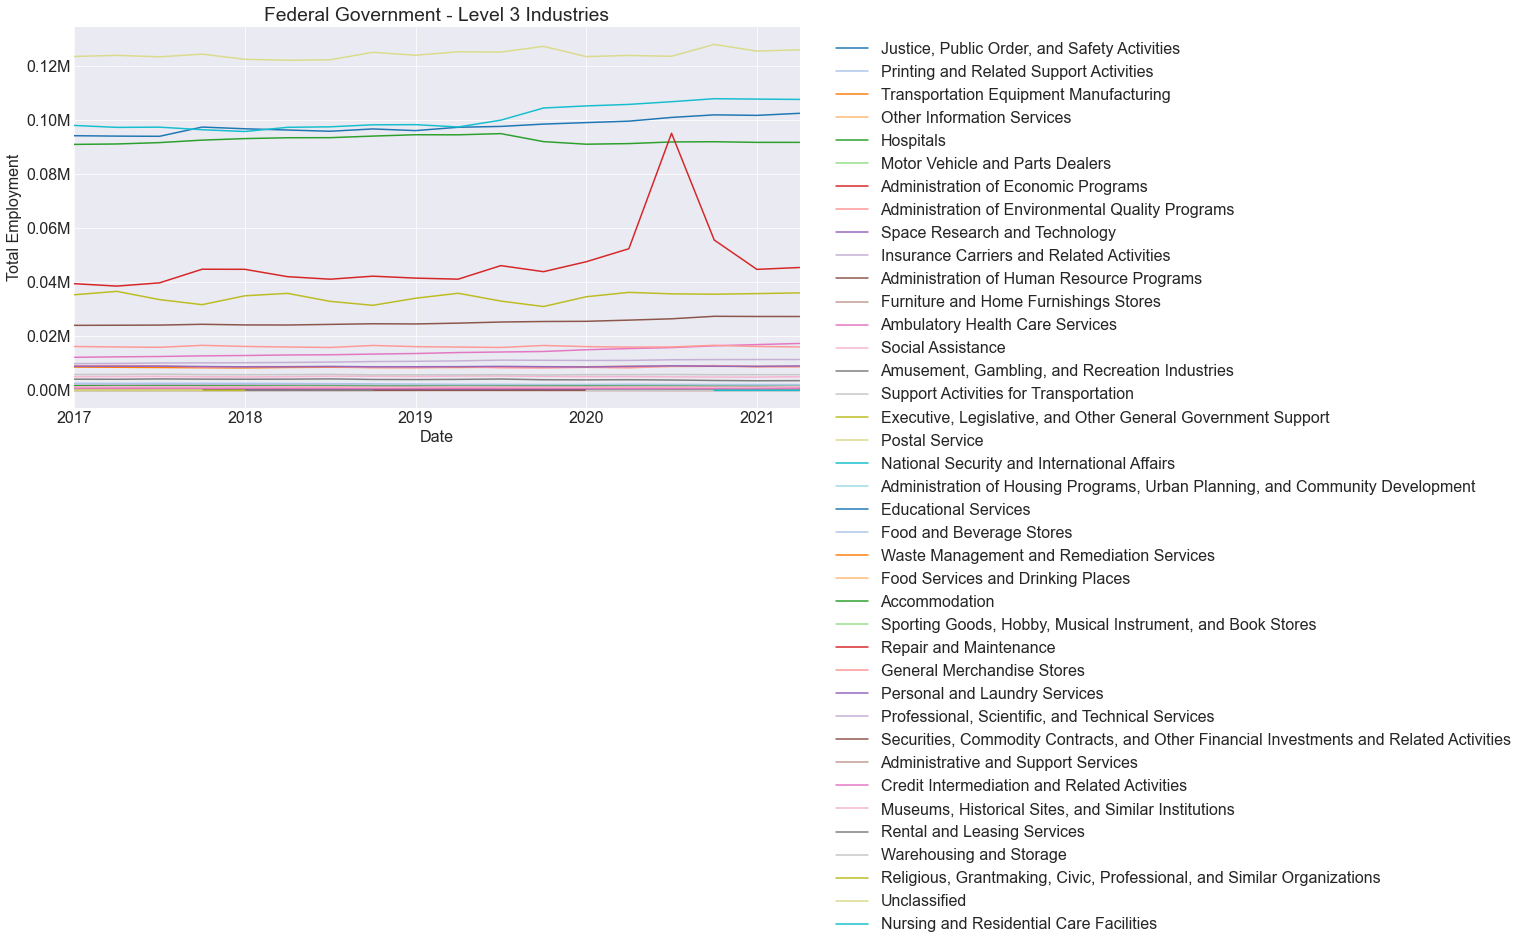

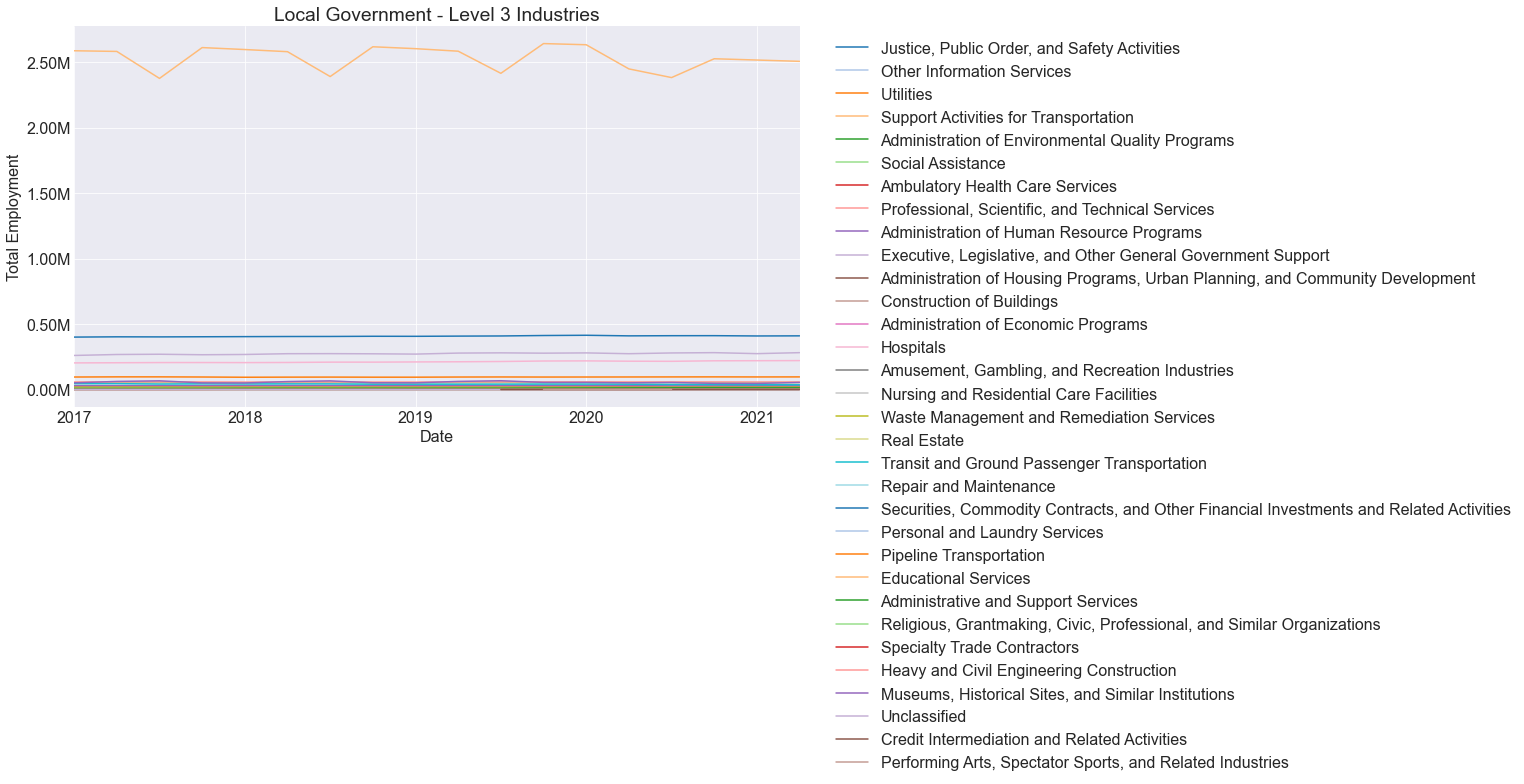

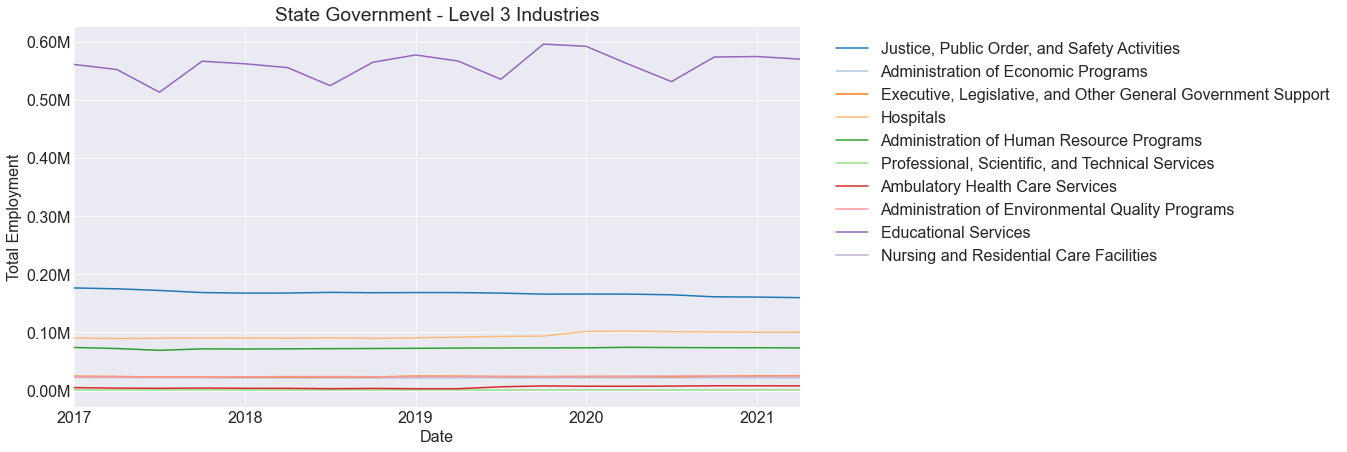

In [184]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 1 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 3 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

# works but has way too many industries to fit on one plot

In [185]:
# write a function that uses 3-digit industry code to get 2 digit industry code and then convert that to industry name 
# (use map function after creating dictionary of codes to names)
df['Code'] = df['Industry Code'].astype('string').apply(lambda x: x[:2])

In [186]:
# df.Code.value_counts().sort_index()

In [187]:
# create mapping dictionary to get industries associated with 2-digit codes
code_mapping_dict = {
    '11' : 'Agriculture, Forestry, Fishing and Hunting',
    '21' : 'Mining, Quarrying, and Oil and Gas Extraction',
    '22' : 'Utilities',
    '23' : 'Construction',
    '31' : 'Manufacturing',
    '32' : 'Manufacturing',
    '33' : 'Manufacturing',
    '42' : 'Wholesale Trade',
    '44' : 'Retail Trade',
    '45' : 'Retail Trade',
    '48' : 'Transportation and Warehousing',
    '49' : 'Transportation and Warehousing',
    '51' : 'Information',
    '52' : 'Finance and Insurance',
    '53' : 'Real Estate and Rental and Leasing',
    '54' : 'Professional, Scientific, and Technical Services',
    '55' : 'Management of Companies and Enterprises',
    '56' : 'Administrative and Support and Waste Management and Remediation Services',
    '61' : 'Educational Services',
    '62' : 'Health Care and Social Assistance',
    '71' : 'Arts, Entertainment, and Recreation',
    '72' : 'Accommodation and Food Services',
    '81' : 'Other Services (except Public Administration)',
    '92' : 'Public Administration',
    '99' : 'Unclassified'
}

In [188]:
# create new column with industry names using map function
df['Parent Industry'] = df.Code.map(code_mapping_dict)

In [189]:
# get list of all unique parent industries
par_ind_list = df['Parent Industry'].value_counts().index.tolist()
par_ind_list

['Manufacturing',
 'Retail Trade',
 'Transportation and Warehousing',
 'Public Administration',
 'Health Care and Social Assistance',
 'Information',
 'Other Services (except Public Administration)',
 'Finance and Insurance',
 'Arts, Entertainment, and Recreation',
 'Agriculture, Forestry, Fishing and Hunting',
 'Construction',
 'Administrative and Support and Waste Management and Remediation Services',
 'Real Estate and Rental and Leasing',
 'Accommodation and Food Services',
 'Wholesale Trade',
 'Mining, Quarrying, and Oil and Gas Extraction',
 'Professional, Scientific, and Technical Services',
 'Educational Services',
 'Unclassified',
 'Utilities',
 'Management of Companies and Enterprises']

In [190]:
# create a dictionary with subset dfs for each parent industry
par_ind_df_dict = {}
for ind in par_ind_list:
    par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

In [191]:
# for par in par_ind_list:
#     df = par_ind_df_dict[par]
    
#     ownership_list = df.Ownership.value_counts().index.tolist()
    
#     ownership_df_dict = {}
#     for own in ownership_list:
#         ownership_df_dict[own] = df[df.Ownership == own]
    
#     for own in ownership_list:
#         ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
#         industry_df_dict = {}
#         for ind in ind_list:
#             industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
# #         for ind in ind_list:
# #             industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
# #         plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - {par} - Level 3 Industries')
# #         plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
# #         plt.legend(bbox_to_anchor= (1.03,1))
# #         plt.show()
#         for ind in ind_list:
#             industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#         plt.gca().set(ylabel = 'Total Employment', title=f'{own} - {par} - Level 3 Industries')
#         plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
#         plt.legend(bbox_to_anchor= (1.03,1))
#         plt.show()

---
#### Just Total All, all industries

In [321]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L3.xlsx')

# add a column for total employment for that row
# df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
# df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

# add first month to year as strings 
# df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

# make a new column that is datetime for first day of each quarter for x axis when plotting
# df['Date'] = pd.to_datetime(df.Quarter)

# only total
df = df[df.Ownership == 'Total All']
# I only want to keep a few columns
df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']]

In [322]:
# # we are looking at a total of 97 industries on a single plot
# ind_list = df.Industry.value_counts().index.tolist()
# #ind_list

# industry_df_dict = {}
# for ind in ind_list:
#     industry_df_dict[ind] = df[df.Industry == ind]

# for ind in ind_list:
#     industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 3 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
# plt.show()

In [323]:
df.head()

Year  Period  Industry Code         Industry  Month 1 Employment  \
1  2017       1            111  Crop Production               19992   
3  2017       2            111  Crop Production               21337   
5  2017       3            111  Crop Production               20982   
7  2017       4            111  Crop Production               21747   
9  2018       1            111  Crop Production               19531   

   Month 2 Employment  Month 3 Employment  
1               20513               21298  
3               21000               21024  
5               20754               20583  
7               22210               21254  
9               20177               20942

In [324]:
# take a look at current number rows
df.shape

(1735, 7)

In [325]:
# we want to create 3 rows for each current row, so our new df should have this many rows
1735 * 3

5205

In [326]:
df.Industry.nunique()

97

In [327]:
# I want to take values for columns 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment' and pivot them into rows while changing dates to year-month-01 for each month
df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment')

In [328]:
df.shape

(5205, 6)

In [329]:
# now let's create plots for each industry
df.head()

Year  Period  Industry Code         Industry               Month  \
0  2017       1            111  Crop Production  Month 1 Employment   
1  2017       2            111  Crop Production  Month 1 Employment   
2  2017       3            111  Crop Production  Month 1 Employment   
3  2017       4            111  Crop Production  Month 1 Employment   
4  2018       1            111  Crop Production  Month 1 Employment   

   Total Employment  
0             19992  
1             21337  
2             20982  
3             21747  
4             19531

In [330]:
df[(df.Year == 2017) & (df.Industry == 'Crop Production')]

Year  Period  Industry Code         Industry               Month  \
0     2017       1            111  Crop Production  Month 1 Employment   
1     2017       2            111  Crop Production  Month 1 Employment   
2     2017       3            111  Crop Production  Month 1 Employment   
3     2017       4            111  Crop Production  Month 1 Employment   
1735  2017       1            111  Crop Production  Month 2 Employment   
1736  2017       2            111  Crop Production  Month 2 Employment   
1737  2017       3            111  Crop Production  Month 2 Employment   
1738  2017       4            111  Crop Production  Month 2 Employment   
3470  2017       1            111  Crop Production  Month 3 Employment   
3471  2017       2            111  Crop Production  Month 3 Employment   
3472  2017       3            111  Crop Production  Month 3 Employment   
3473  2017       4            111  Crop Production  Month 3 Employment   

      Total Employment  
0                19992  
1                21337  
2                20982  
3                21747  
1735             20513  
1736             21000  
1737             20754  
1738             22210  
3470             21298  
3471             21024  
3472             20583  
3473             21254

In [331]:
# use string method to pull out numbers from Month column
df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0])

In [332]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment
0  2017       1            111  Crop Production      1             19992
1  2017       2            111  Crop Production      1             21337
2  2017       3            111  Crop Production      1             20982
3  2017       4            111  Crop Production      1             21747
4  2018       1            111  Crop Production      1             19531

In [333]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              5205 non-null   int64 
 1   Period            5205 non-null   int64 
 2   Industry Code     5205 non-null   int64 
 3   Industry          5205 non-null   object
 4   Month             5205 non-null   int64 
 5   Total Employment  5205 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 244.1+ KB


https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

In [334]:
# create a function that takes each row and creates a date column for the observation
def extract_date(df):
    if (df[1] == 1) & (df[4] == 1): # first quarter, first month
        return str(df[0]) + '-' + '01' # January
    elif (df[1] == 1) & (df[4] == 2):
        return str(df[0]) + '-' + '02'
    elif (df[1] == 1) & (df[4] == 3):
        return str(df[0]) + '-' + '03'
    elif (df[1] == 2) & (df[4] == 1):
        return str(df[0]) + '-' + '04'
    elif (df[1] == 2) & (df[4] == 2):
        return str(df[0]) + '-' + '05'
    elif (df[1] == 2) & (df[4] == 3):
        return str(df[0]) + '-' + '06'
    elif (df[1] == 3) & (df[4] == 1):
        return str(df[0]) + '-' + '07'
    elif (df[1] == 3) & (df[4] == 2):
        return str(df[0]) + '-' + '08'
    elif (df[1] == 3) & (df[4] == 3):
        return str(df[0]) + '-' + '09'
    elif (df[1] == 4) & (df[4] == 1):
        return str(df[0]) + '-' + '10'
    elif (df[1] == 4) & (df[4] == 2):
        return str(df[0]) + '-' + '11'
    elif (df[1] == 4) & (df[4] == 3):
        return str(df[0]) + '-' + '12'

In [335]:
df['Date'] = df.apply(extract_date, axis=1)

In [336]:
df.Date = pd.to_datetime(df.Date)

In [337]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date  
0 2017-01-01  
1 2017-04-01  
2 2017-07-01  
3 2017-10-01  
4 2018-01-01

In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              5205 non-null   int64         
 1   Period            5205 non-null   int64         
 2   Industry Code     5205 non-null   int64         
 3   Industry          5205 non-null   object        
 4   Month             5205 non-null   int64         
 5   Total Employment  5205 non-null   int64         
 6   Date              5205 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 284.8+ KB


<AxesSubplot:xlabel='Date'>

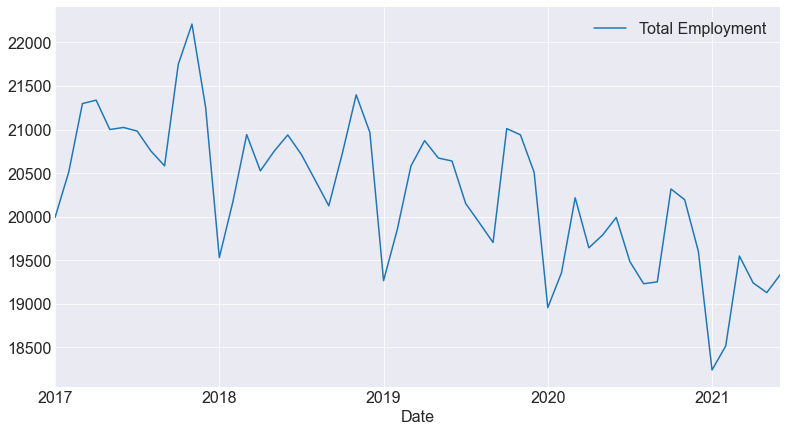

In [339]:
# now plot these for one industry
df[df.Industry == 'Crop Production'].sort_values(by='Date')[['Date', 'Total Employment']].set_index('Date').sort_index().plot()

In [340]:
# now plot for each subsector

In [341]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date  
0 2017-01-01  
1 2017-04-01  
2 2017-07-01  
3 2017-10-01  
4 2018-01-01

In [342]:
# write a function that uses 3-digit industry code to get 2 digit industry code and then convert that to industry name 
# (use map function after creating dictionary of codes to names)
df['Code'] = df['Industry Code'].astype('string').apply(lambda x: x[:2])

In [343]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date Code  
0 2017-01-01   11  
1 2017-04-01   11  
2 2017-07-01   11  
3 2017-10-01   11  
4 2018-01-01   11

In [344]:
# create mapping dictionary to get industries associated with 2-digit codes
code_mapping_dict = {
    '11' : 'Agriculture, Forestry, Fishing and Hunting',
    '21' : 'Mining, Quarrying, and Oil and Gas Extraction',
    '22' : 'Utilities',
    '23' : 'Construction',
    '31' : 'Manufacturing',
    '32' : 'Manufacturing',
    '33' : 'Manufacturing',
    '42' : 'Wholesale Trade',
    '44' : 'Retail Trade',
    '45' : 'Retail Trade',
    '48' : 'Transportation and Warehousing',
    '49' : 'Transportation and Warehousing',
    '51' : 'Information',
    '52' : 'Finance and Insurance',
    '53' : 'Real Estate and Rental and Leasing',
    '54' : 'Professional, Scientific, and Technical Services',
    '55' : 'Management of Companies and Enterprises',
    '56' : 'Administrative and Support and Waste Management and Remediation Services',
    '61' : 'Educational Services',
    '62' : 'Health Care and Social Assistance',
    '71' : 'Arts, Entertainment, and Recreation',
    '72' : 'Accommodation and Food Services',
    '81' : 'Other Services (except Public Administration)',
    '92' : 'Public Administration',
    '99' : 'Unclassified'
}

In [345]:
# create new column with industry names using map function
df['Parent Industry'] = df.Code.map(code_mapping_dict)

In [346]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date Code                             Parent Industry  
0 2017-01-01   11  Agriculture, Forestry, Fishing and Hunting  
1 2017-04-01   11  Agriculture, Forestry, Fishing and Hunting  
2 2017-07-01   11  Agriculture, Forestry, Fishing and Hunting  
3 2017-10-01   11  Agriculture, Forestry, Fishing and Hunting  
4 2018-01-01   11  Agriculture, Forestry, Fishing and Hunting

In [347]:
# get list of all unique parent industries
par_ind_list = df['Parent Industry'].value_counts().index.tolist()

In [348]:
# # create a dictionary with subset dfs for each parent industry
# par_ind_df_dict = {}
# for ind in par_ind_list:
#     par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

# for par in par_ind_list:
#     df = par_ind_df_dict[par]
#     ind_list = df.Industry.value_counts().index.tolist()
#     industry_df_dict = {}
#     for ind in ind_list:
#         industry_df_dict[ind] = df[df.Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()

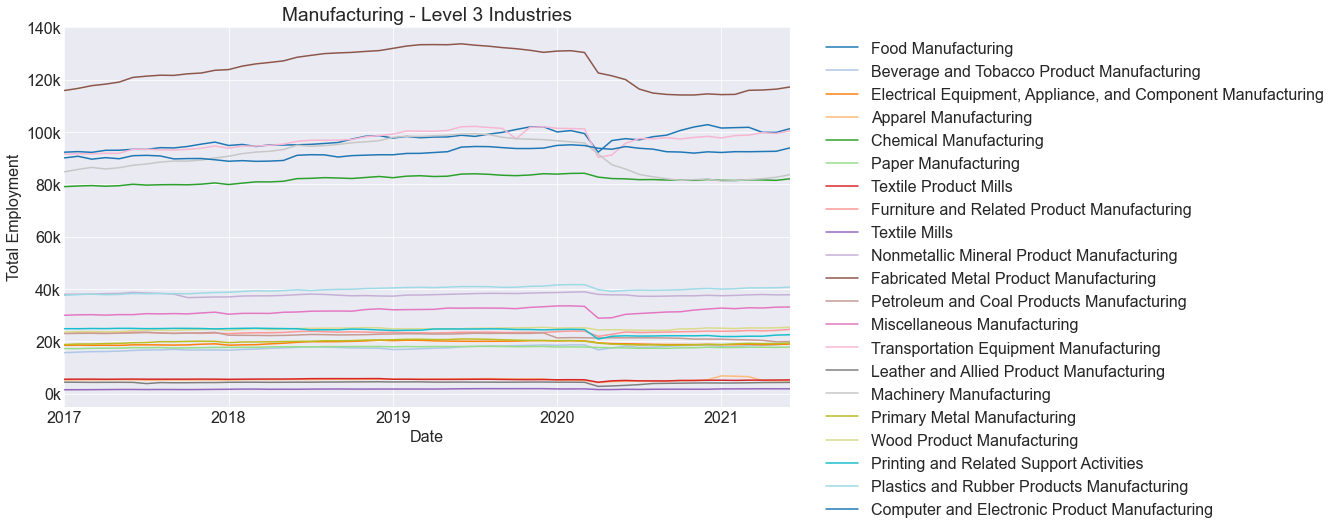

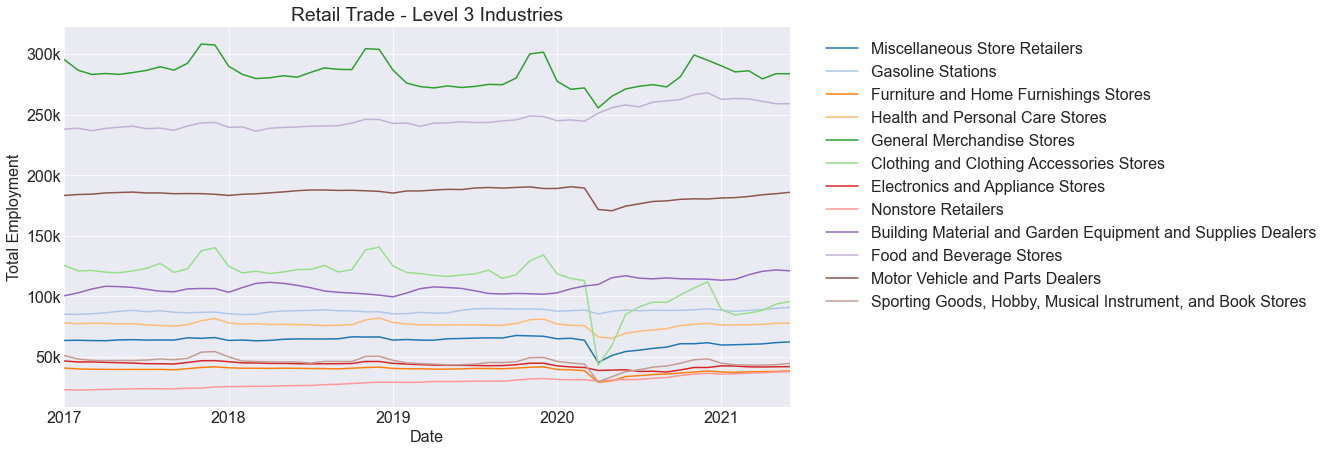

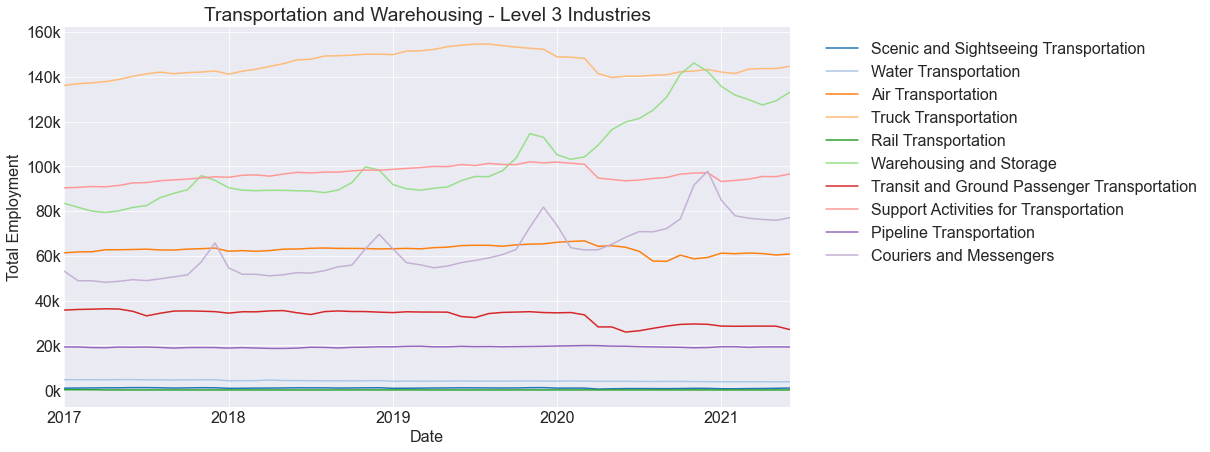

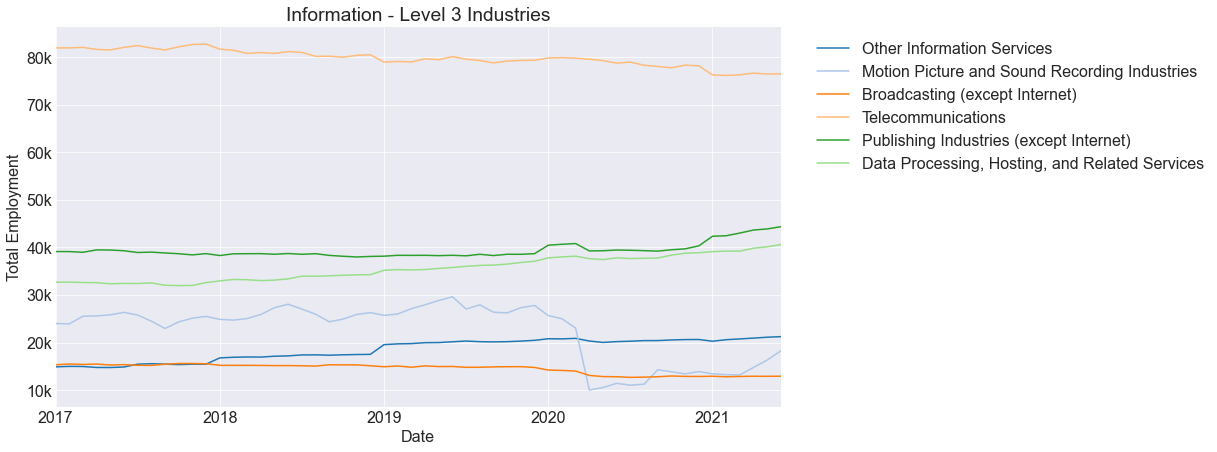

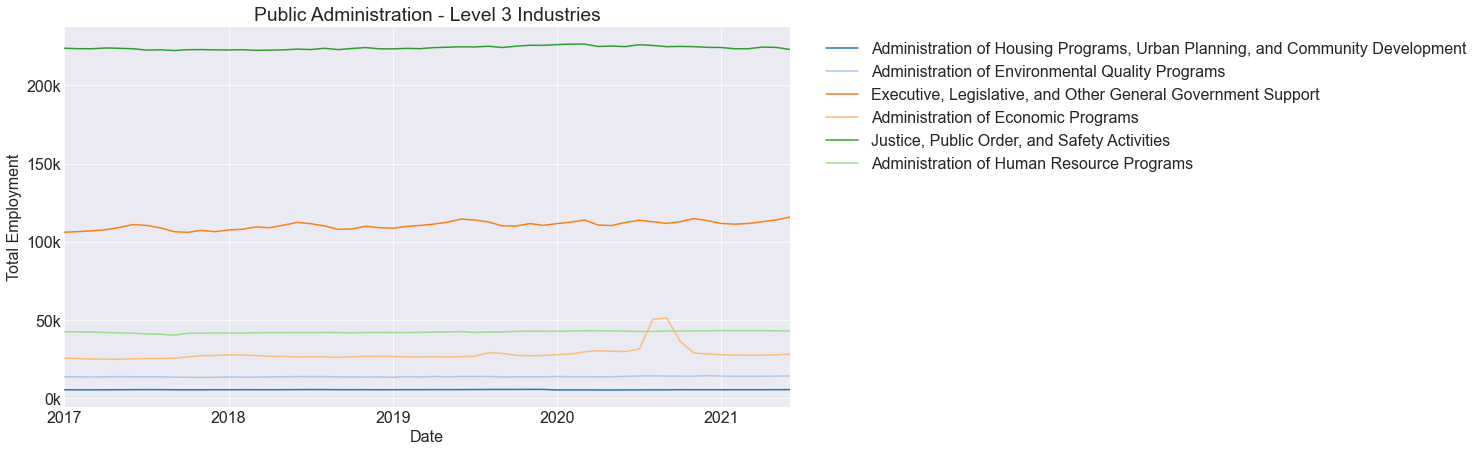

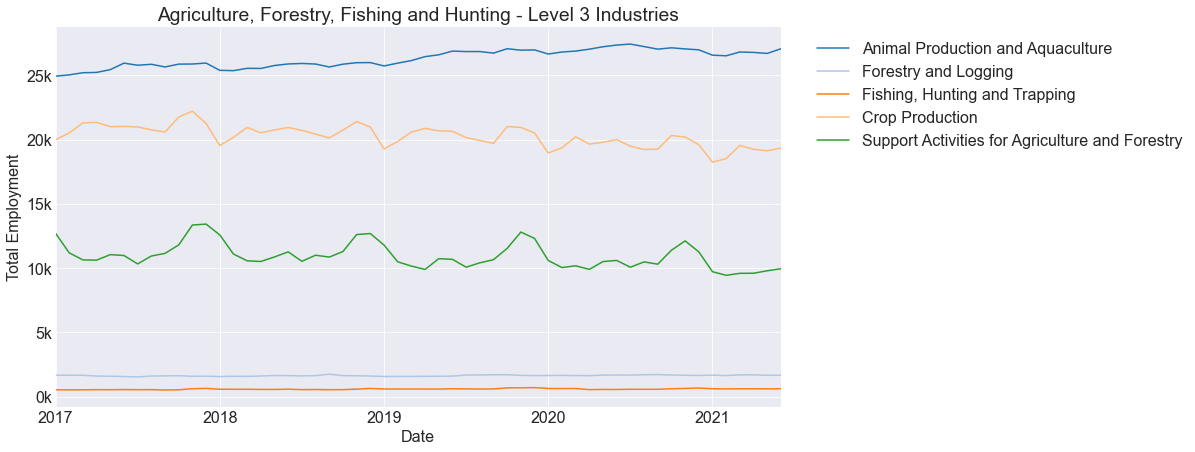

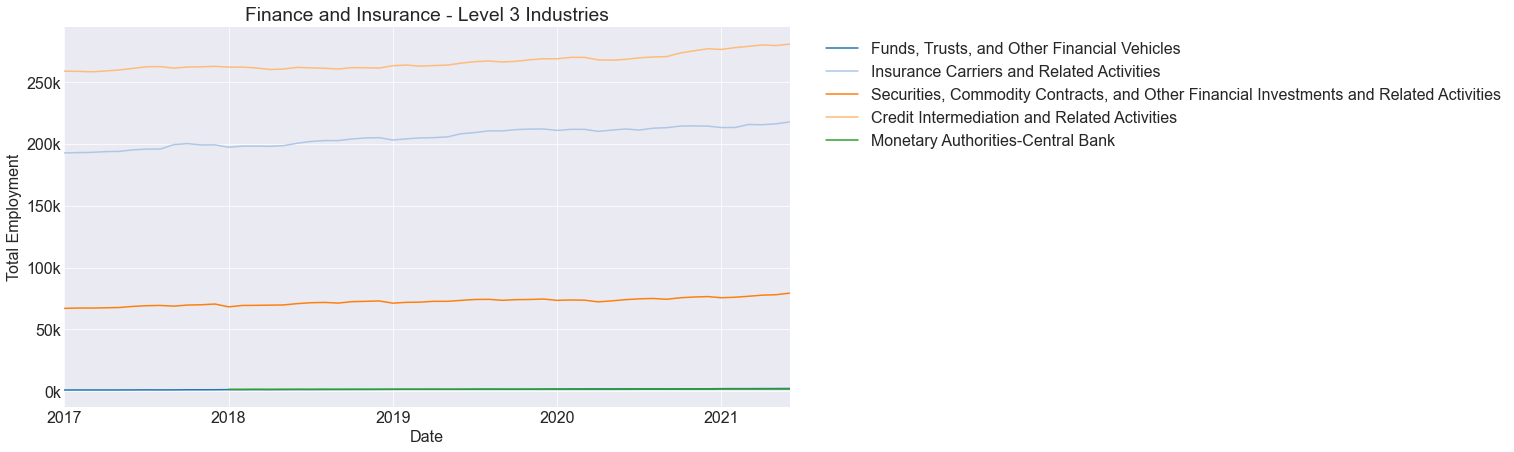

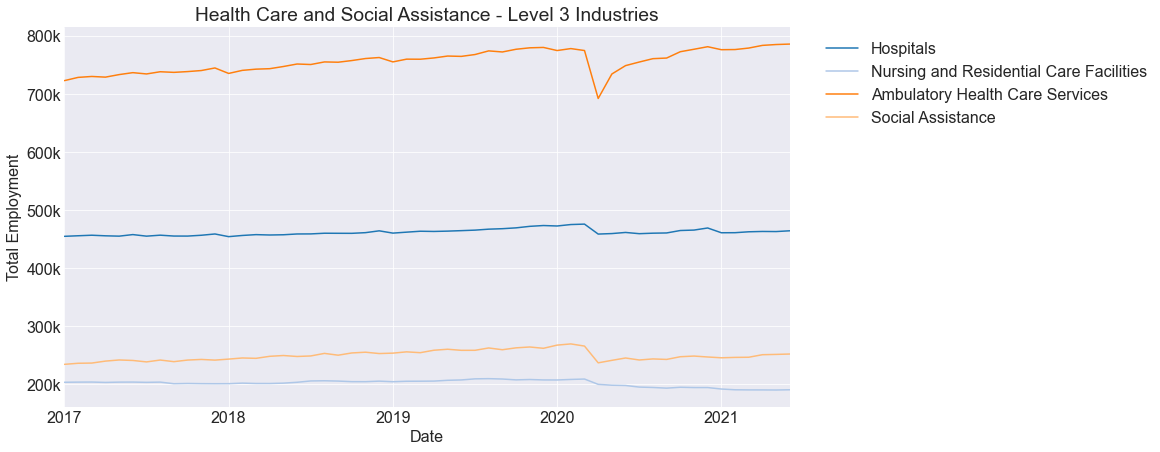

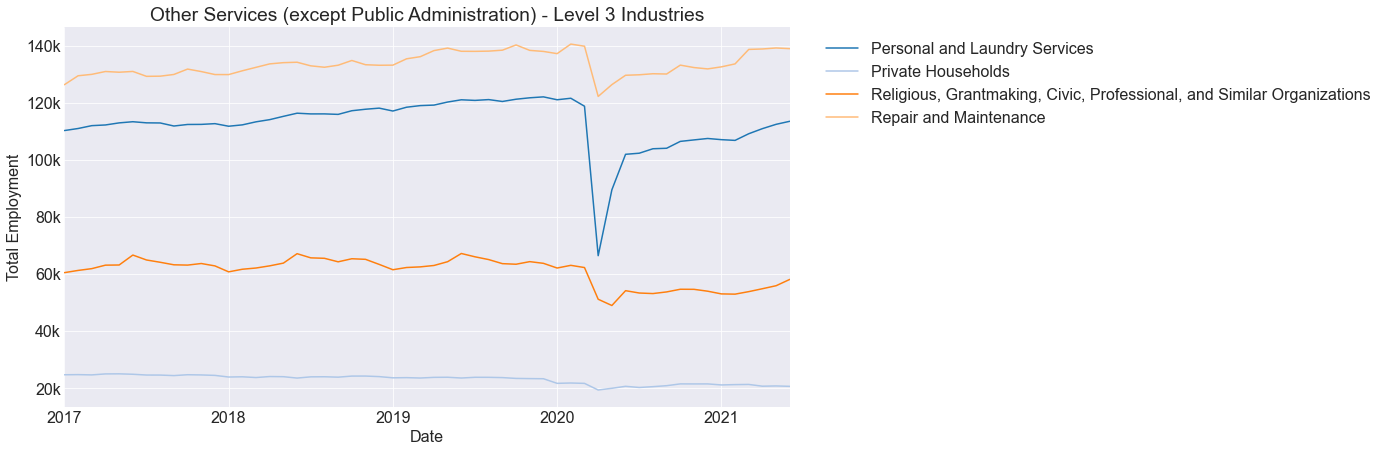

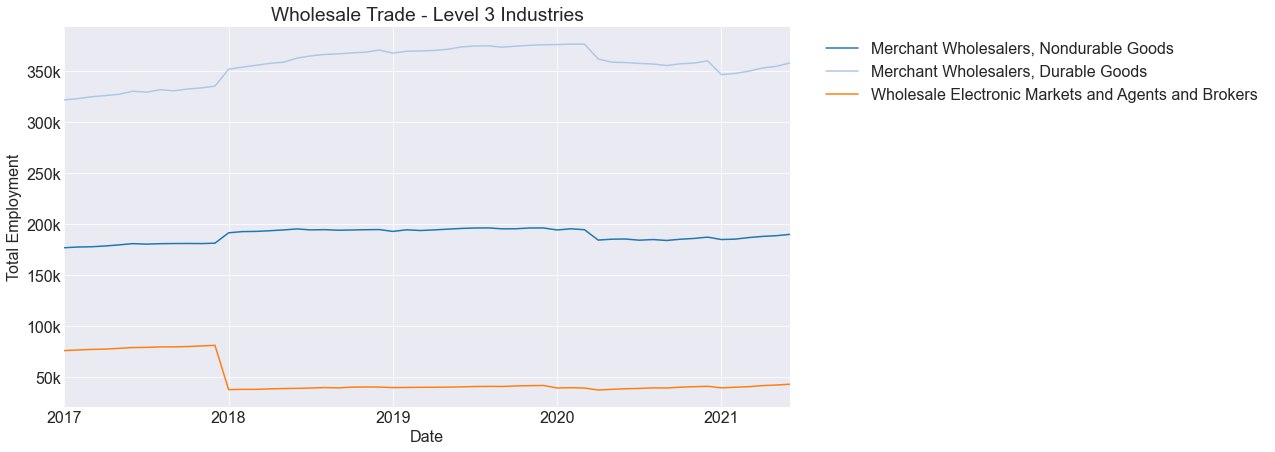

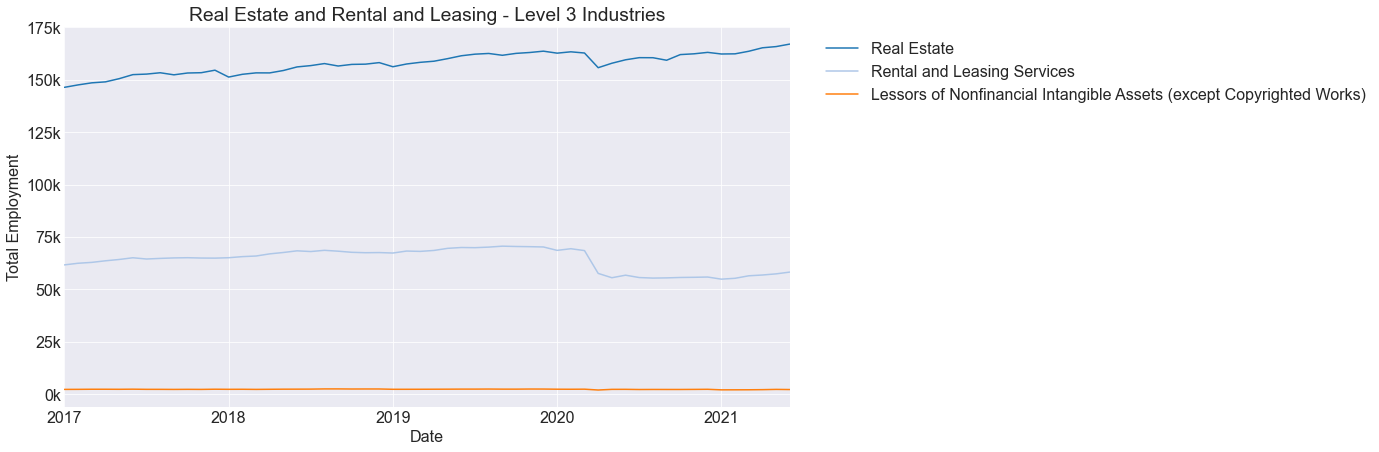

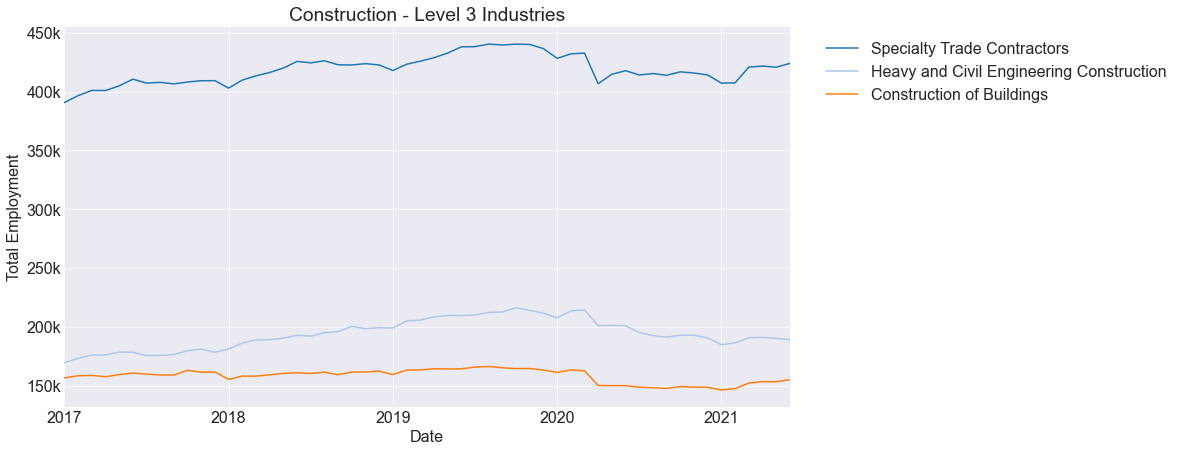

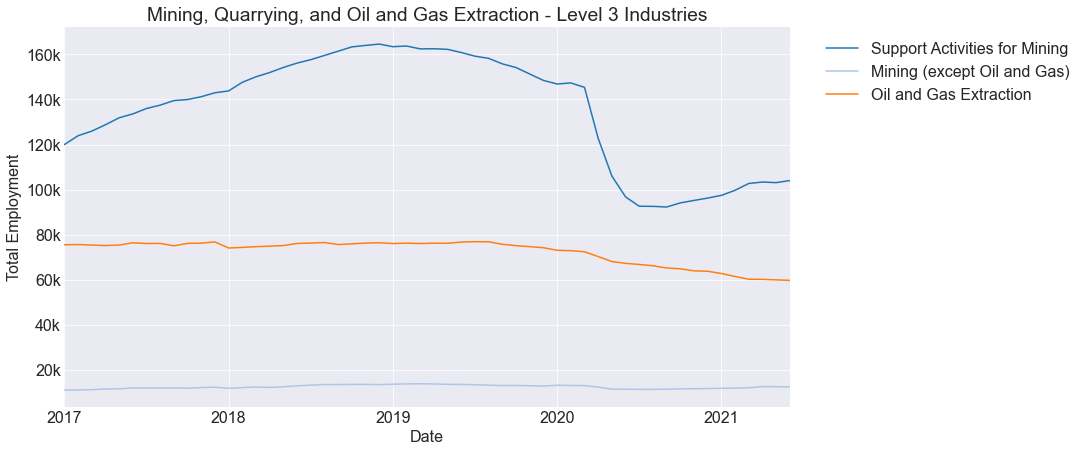

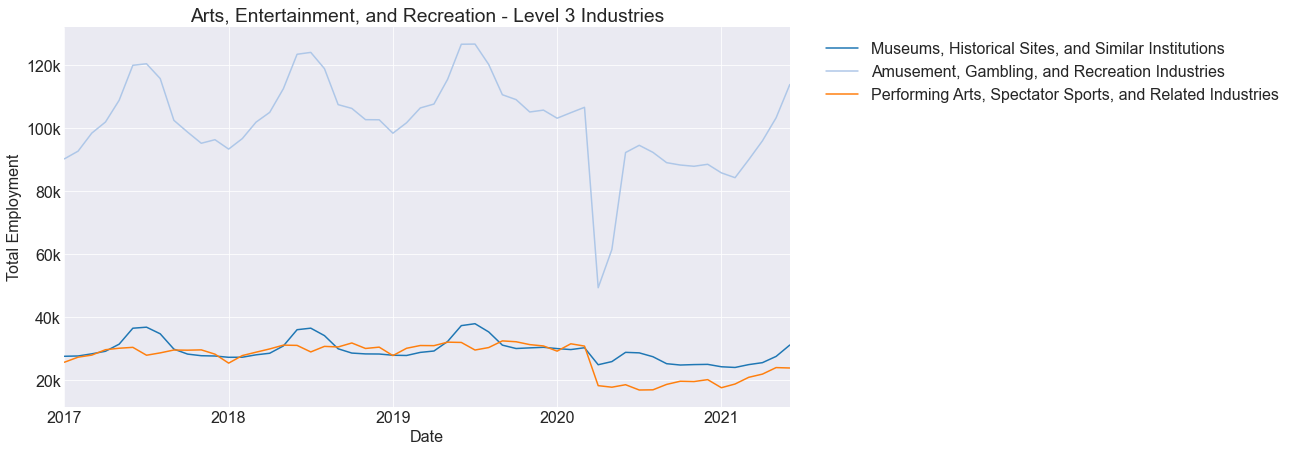

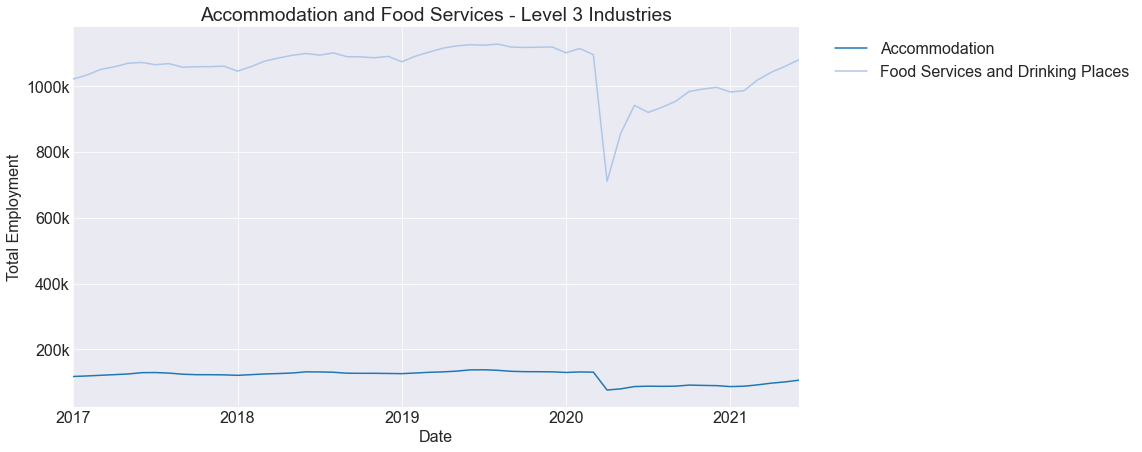

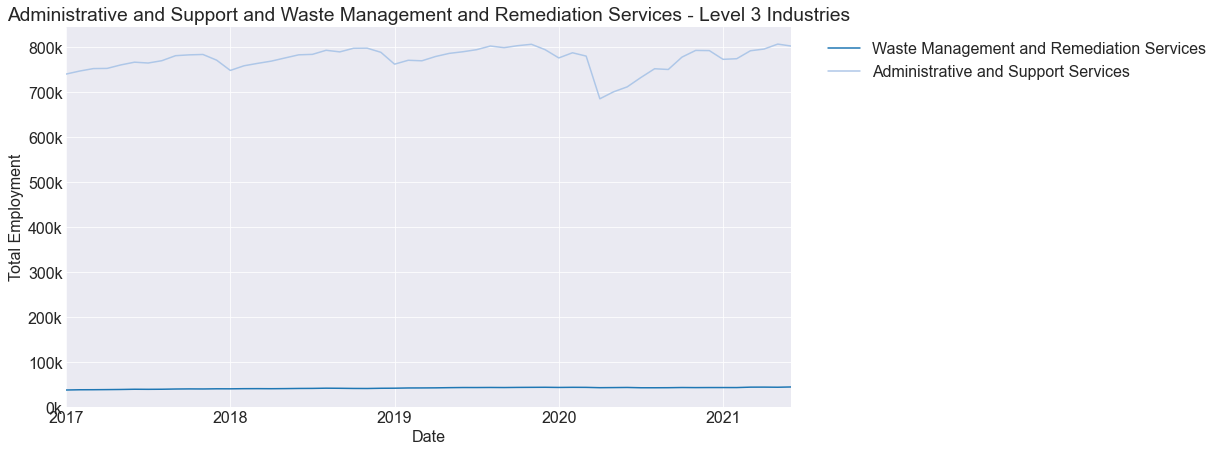

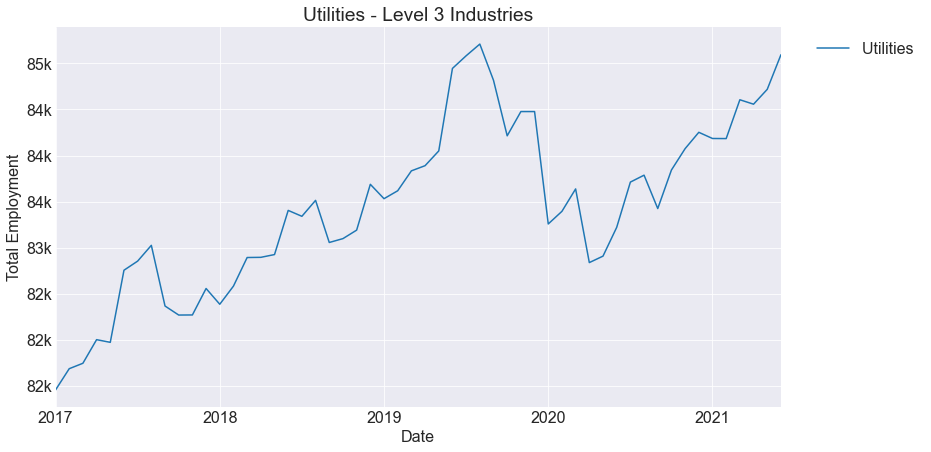

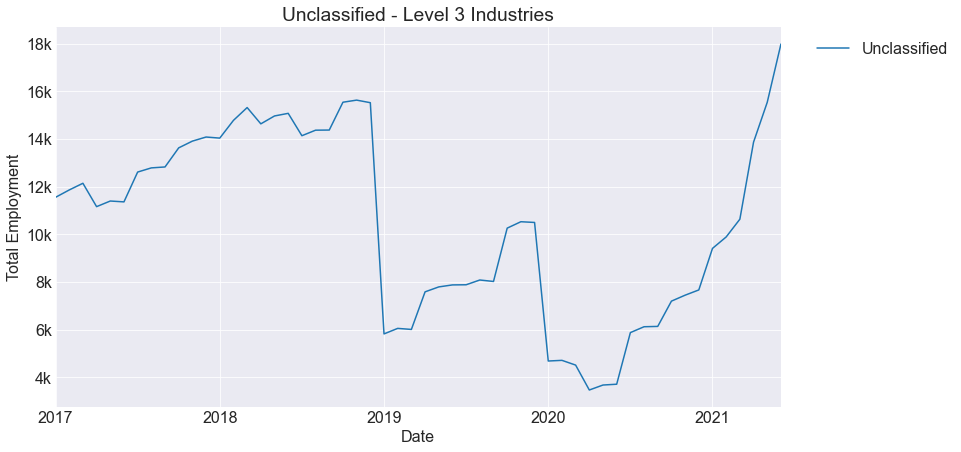

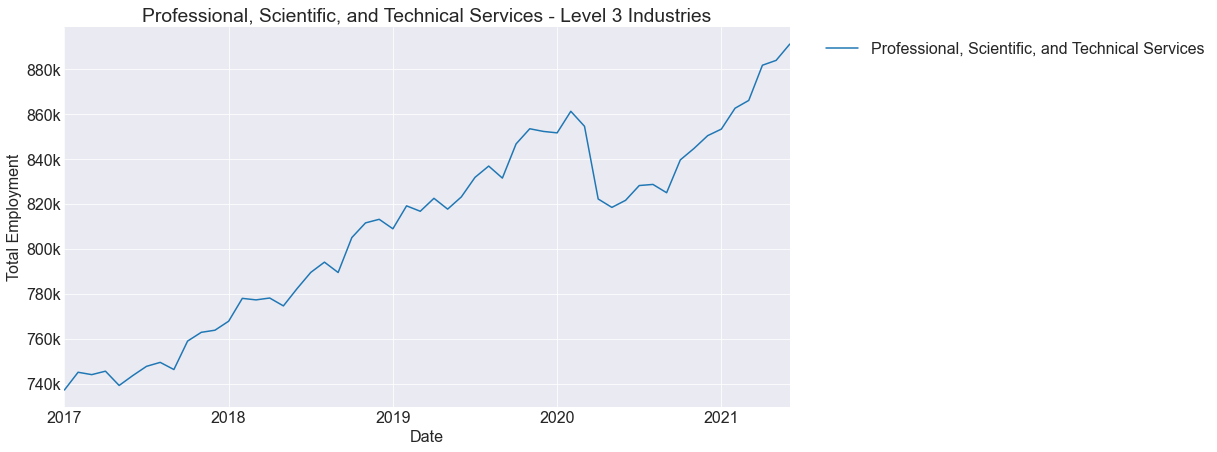

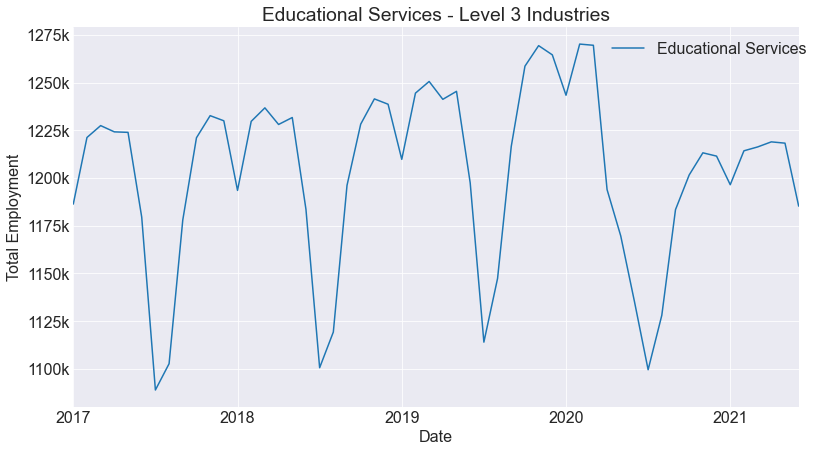

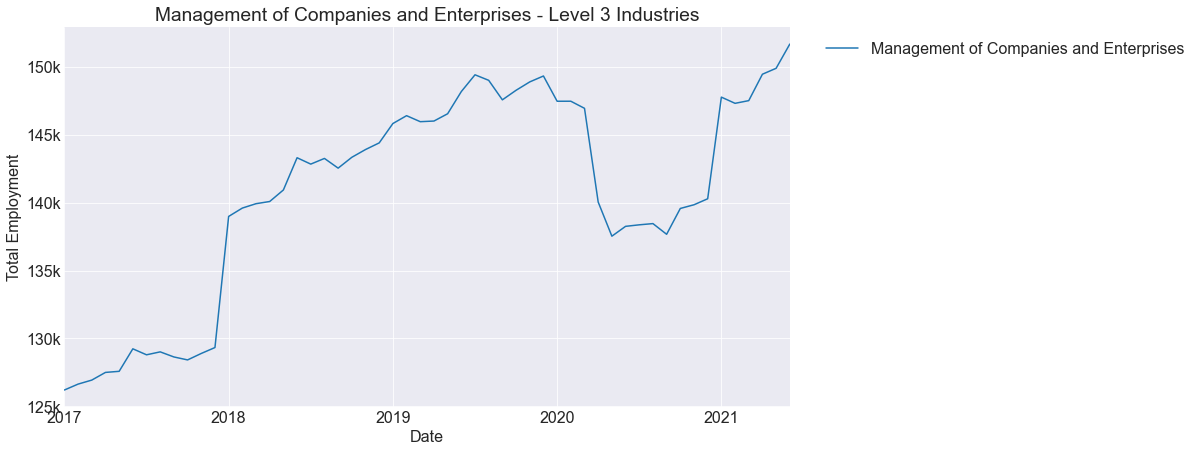

In [349]:
# create a dictionary with subset dfs for each parent industry
par_ind_df_dict = {}
for ind in par_ind_list:
    par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

for par in par_ind_list:
    par_df = par_ind_df_dict[par]
    ind_list = par_df.Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = par_df[par_df.Industry == ind]
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

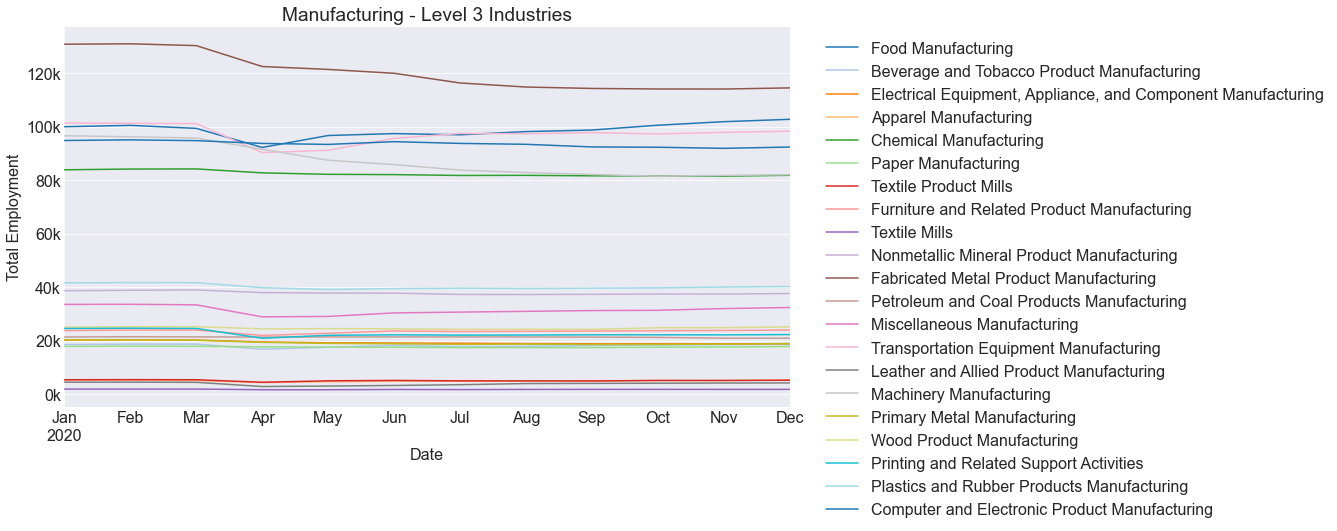

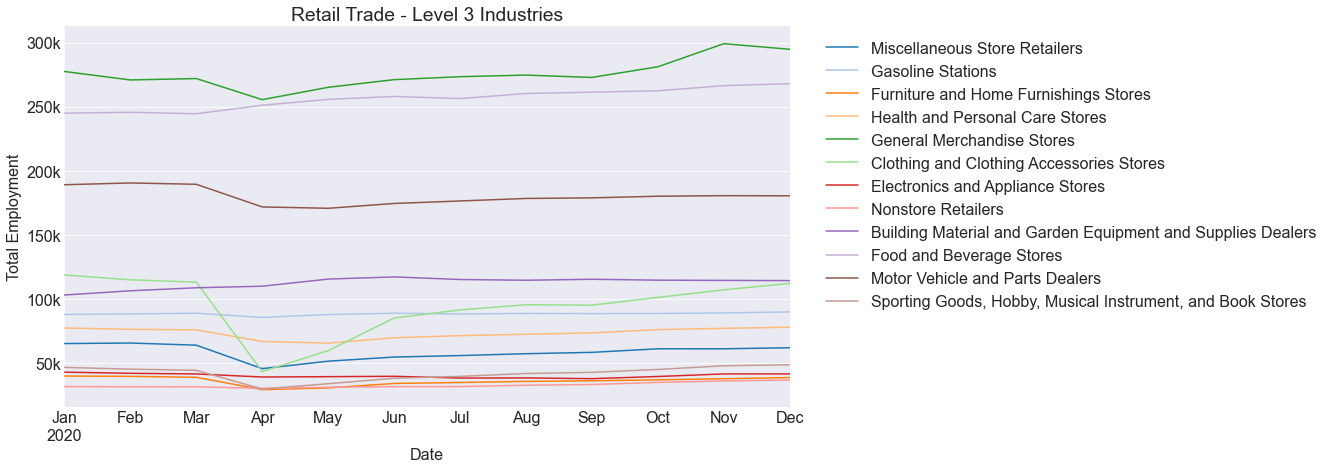

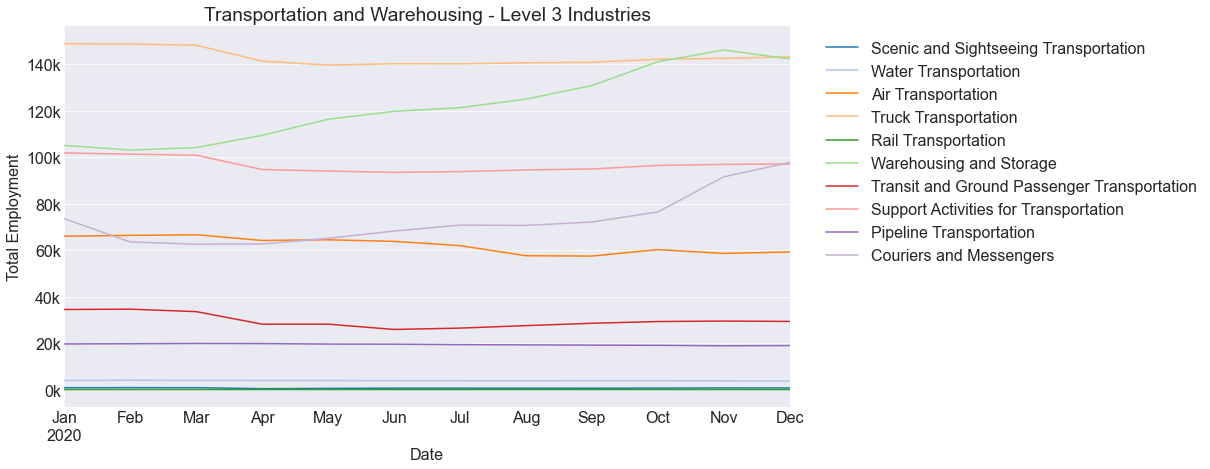

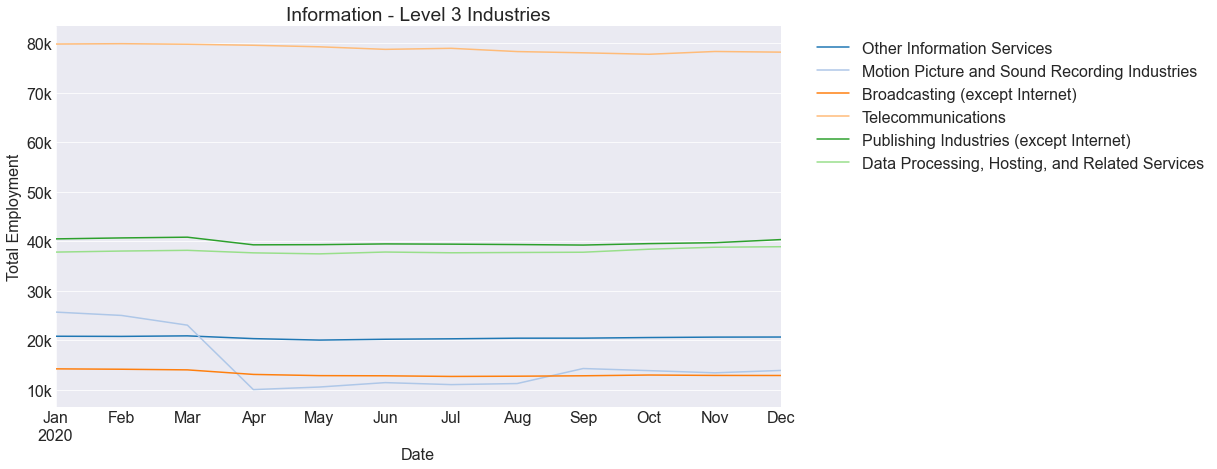

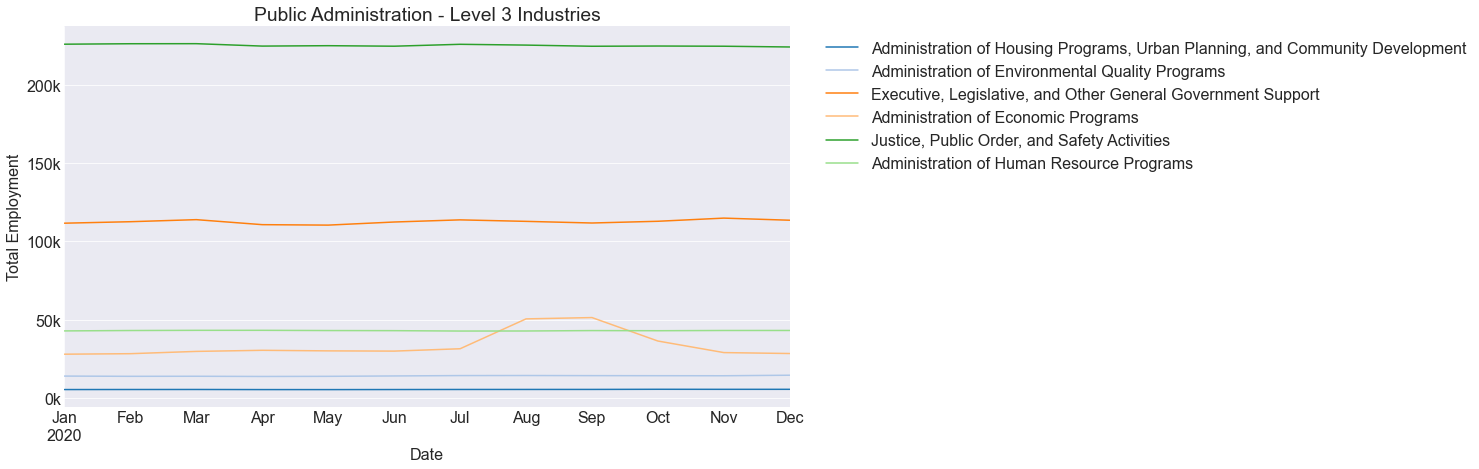

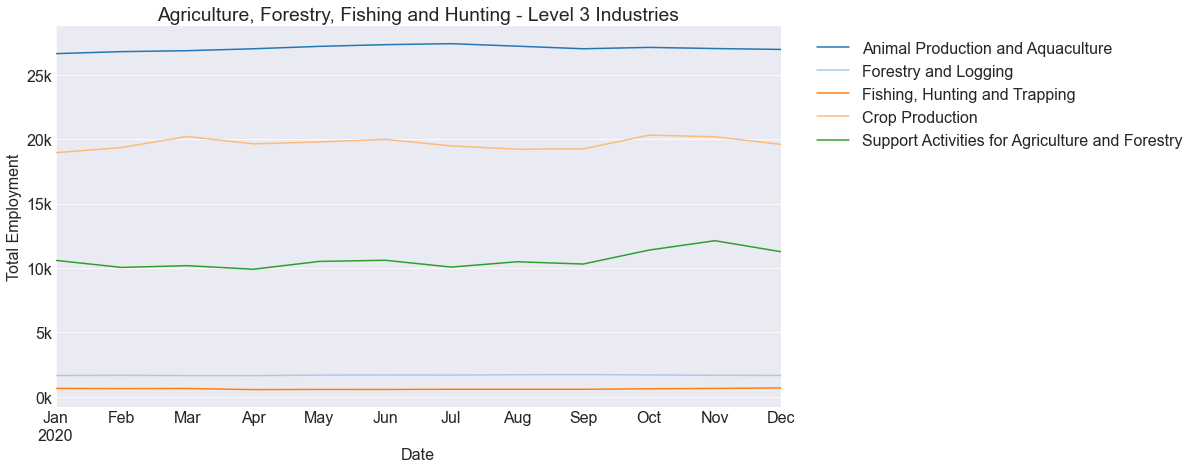

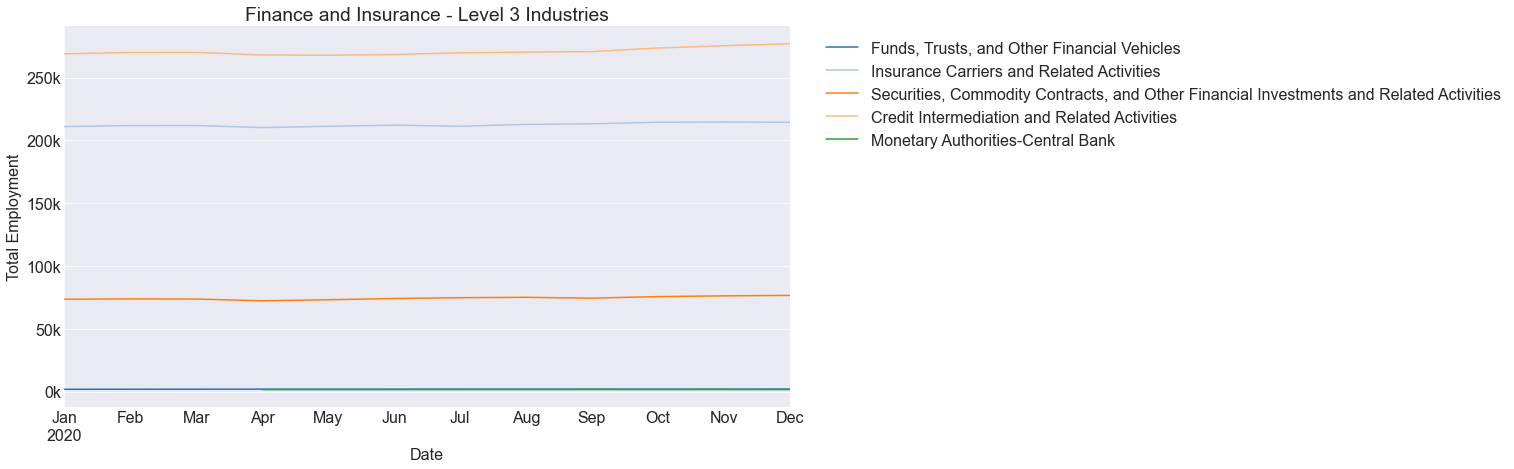

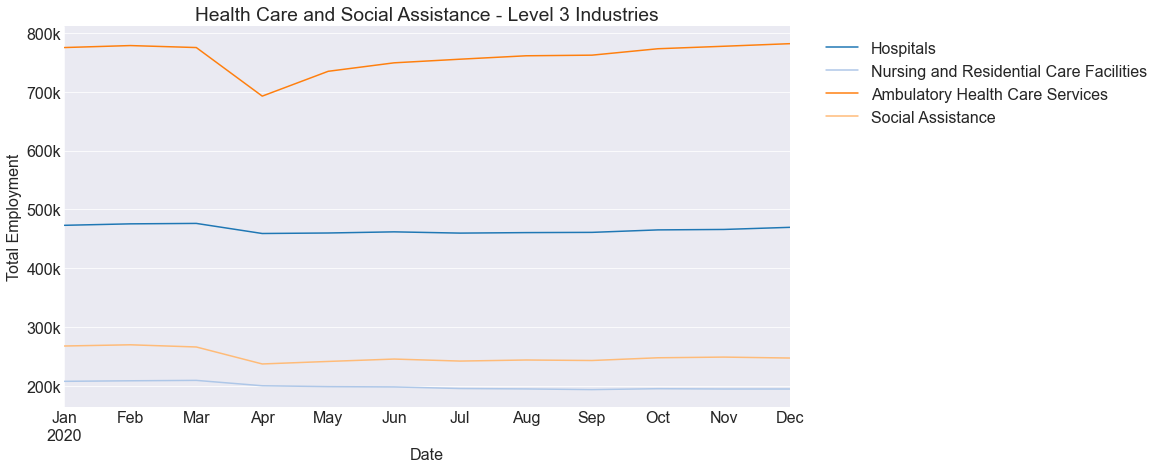

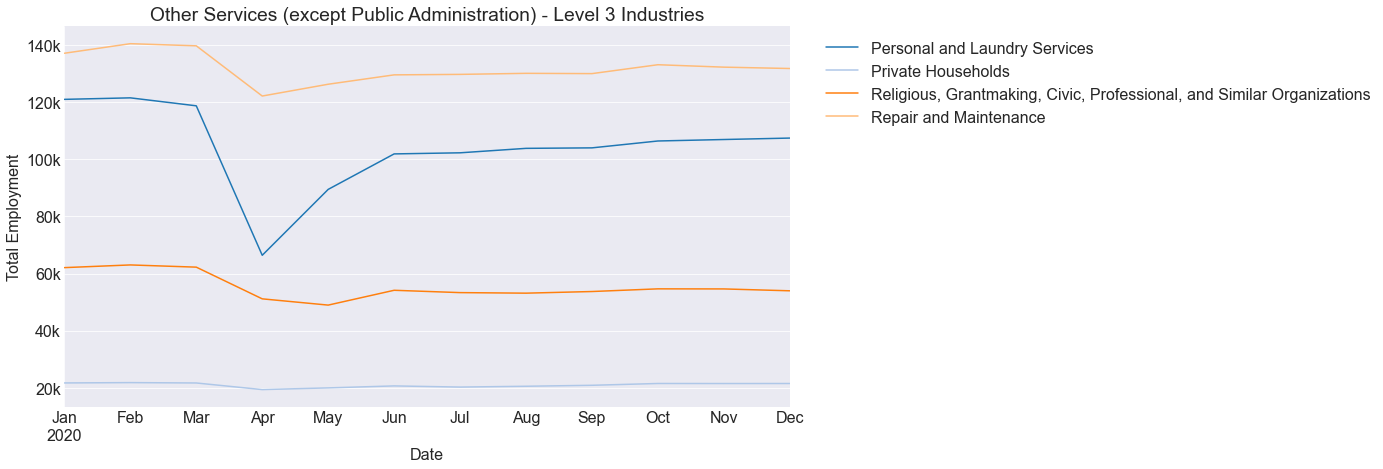

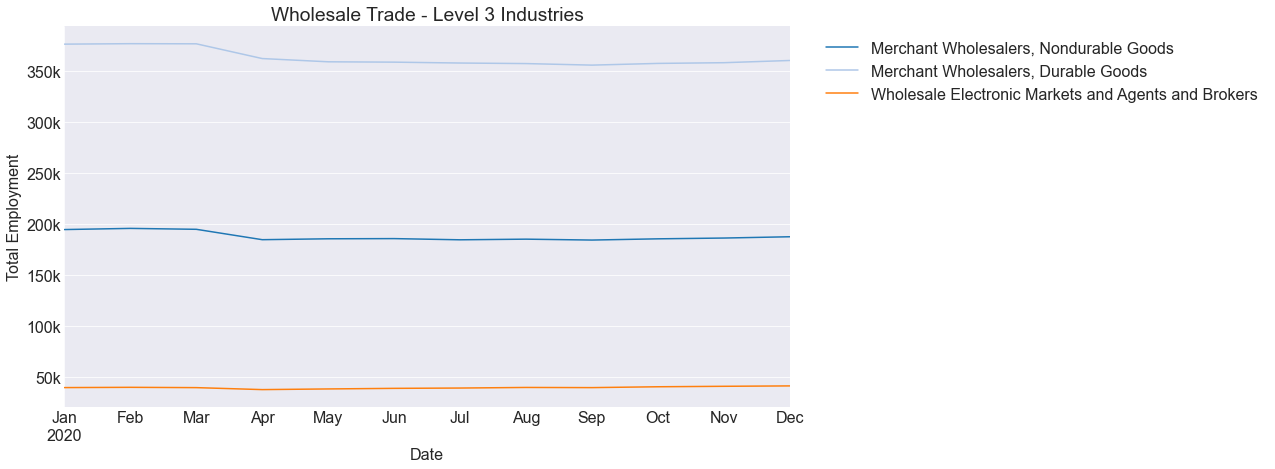

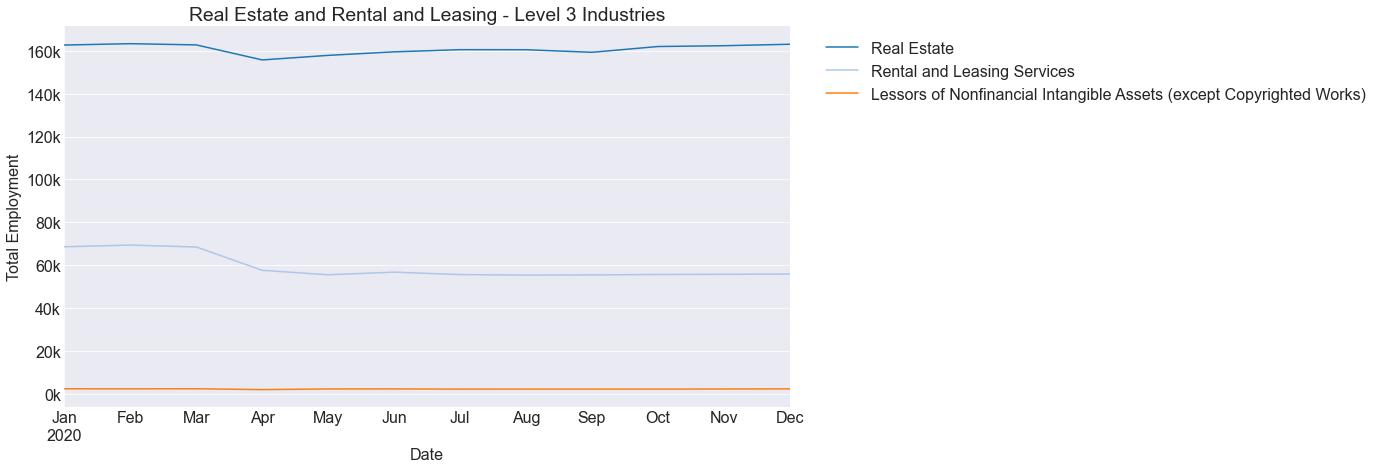

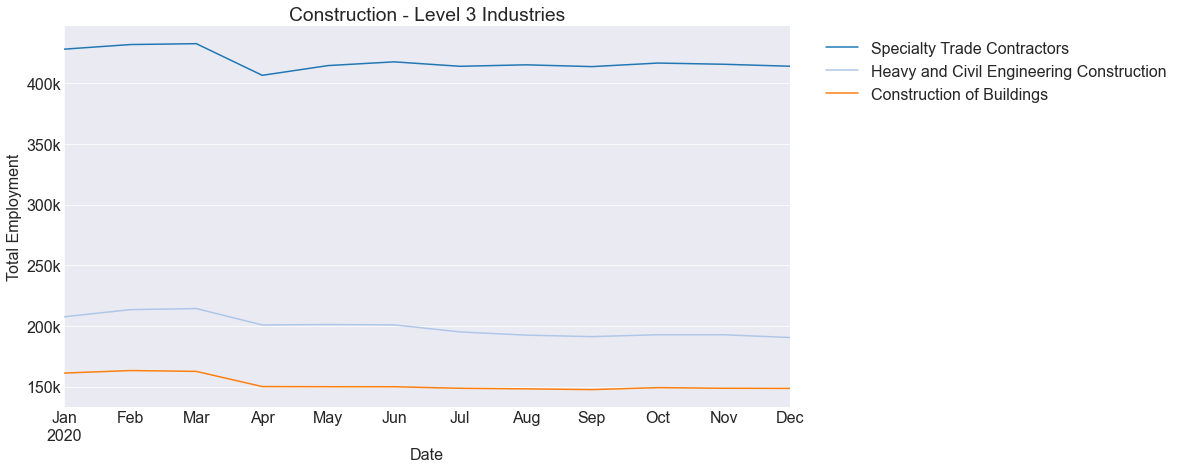

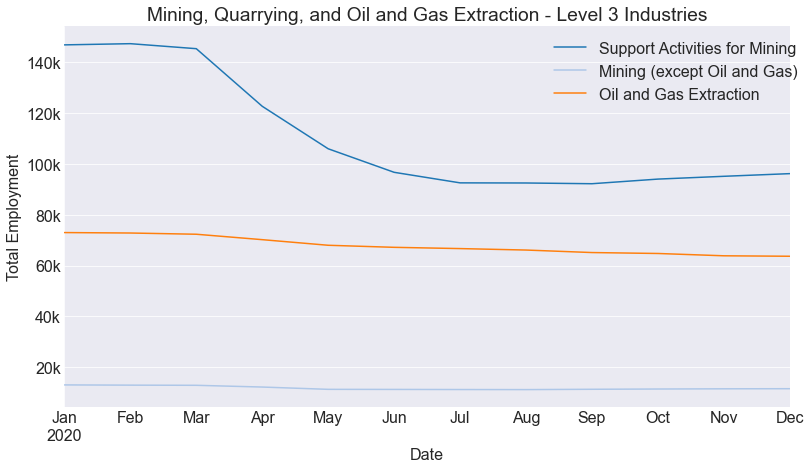

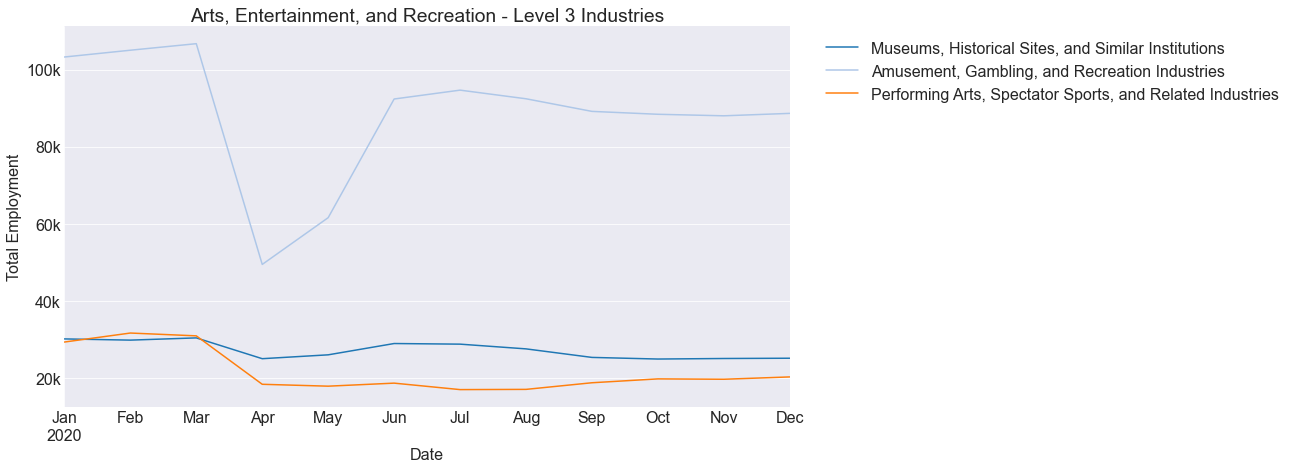

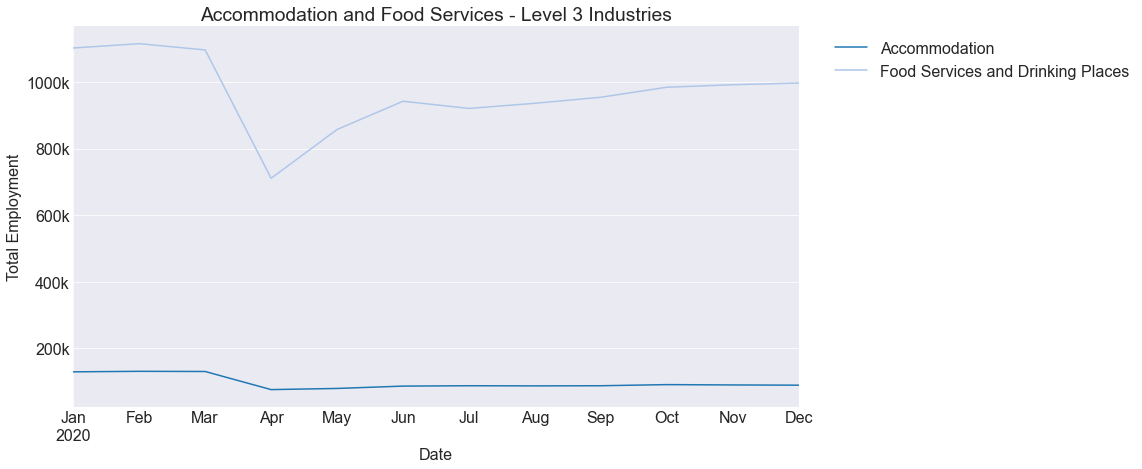

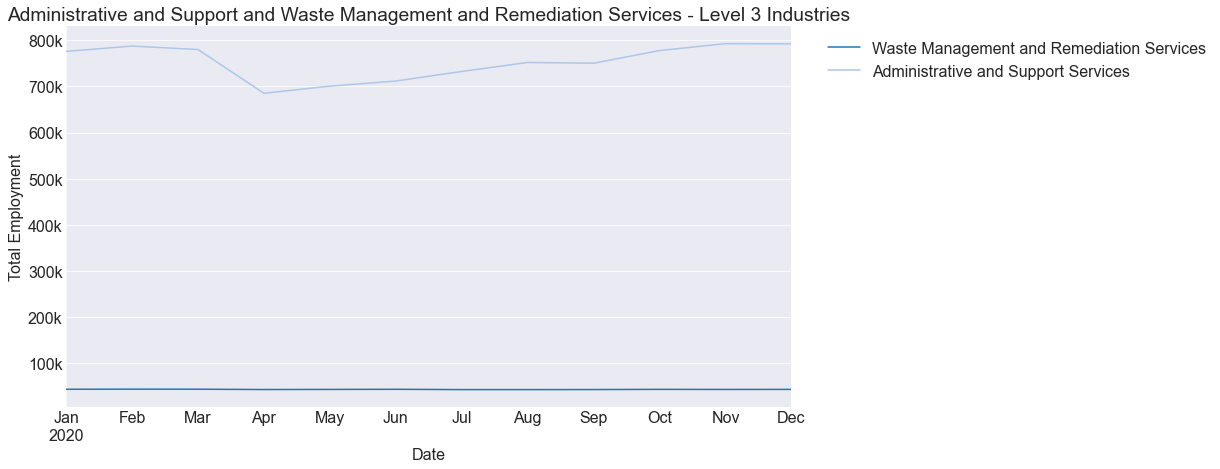

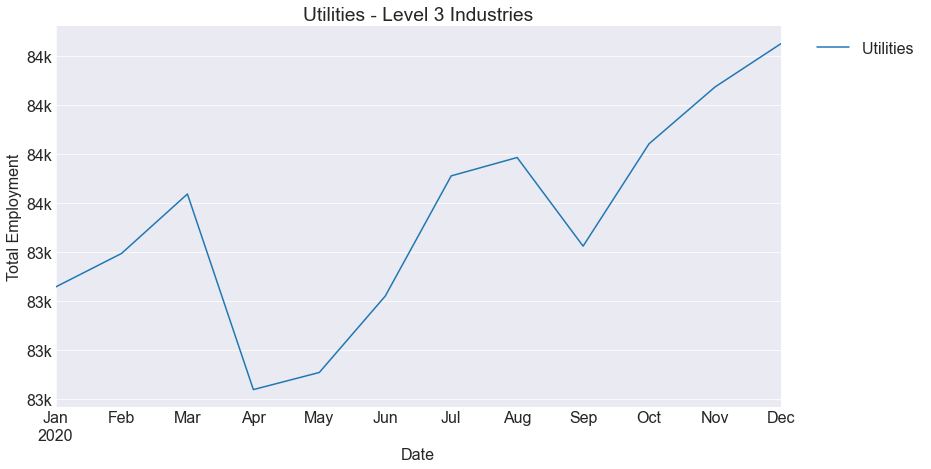

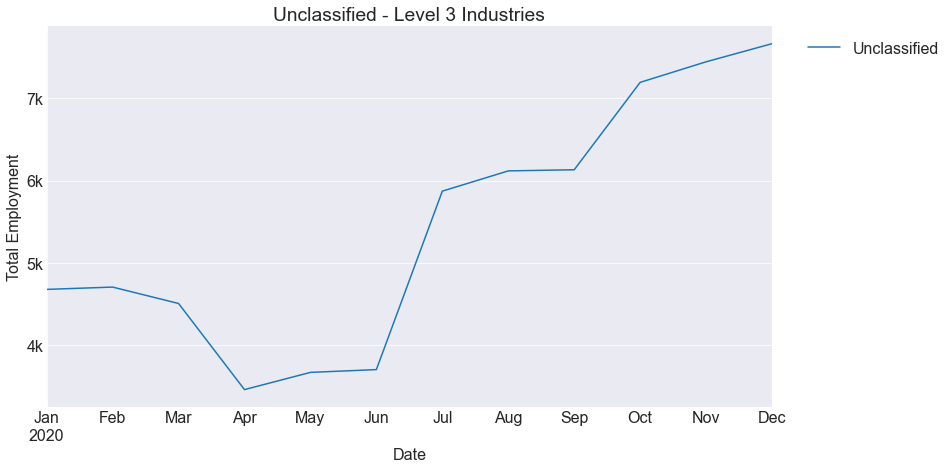

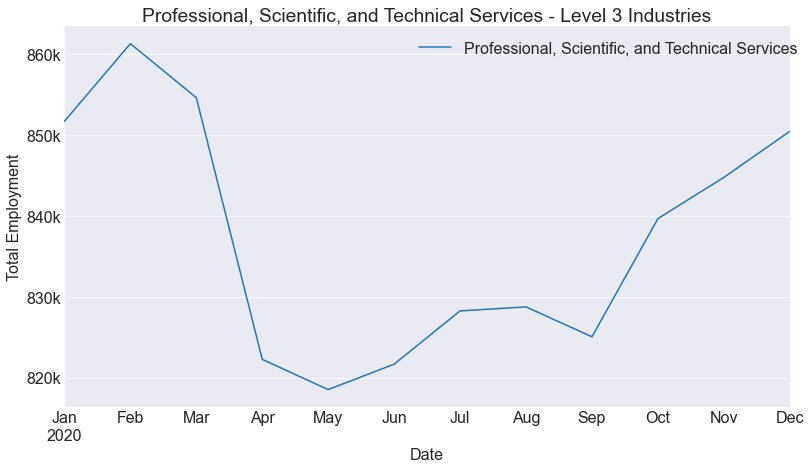

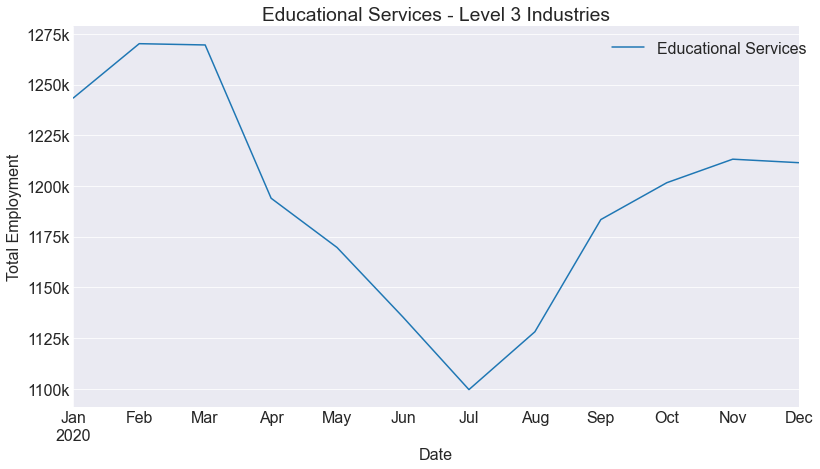

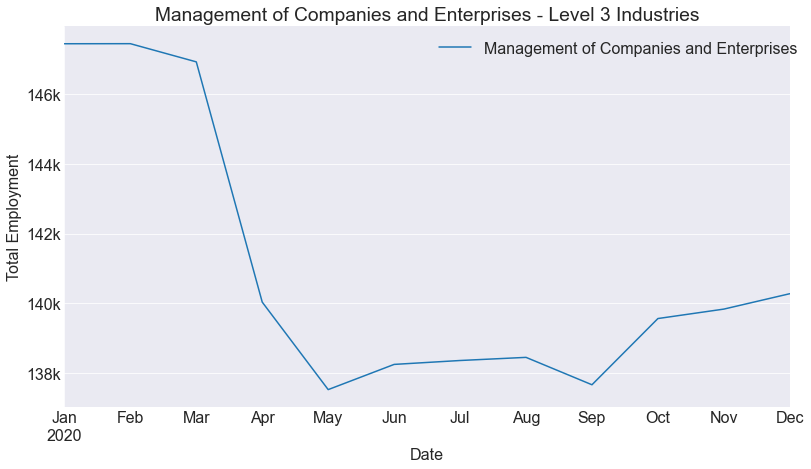

In [350]:
# create a dictionary with subset dfs for each parent industry
par_ind_df_dict = {}
for ind in par_ind_list:
    par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

for par in par_ind_list:
    par_df = par_ind_df_dict[par]
    ind_list = par_df.Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = par_df[par_df.Industry == ind]
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment']['2020'].sort_index().plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

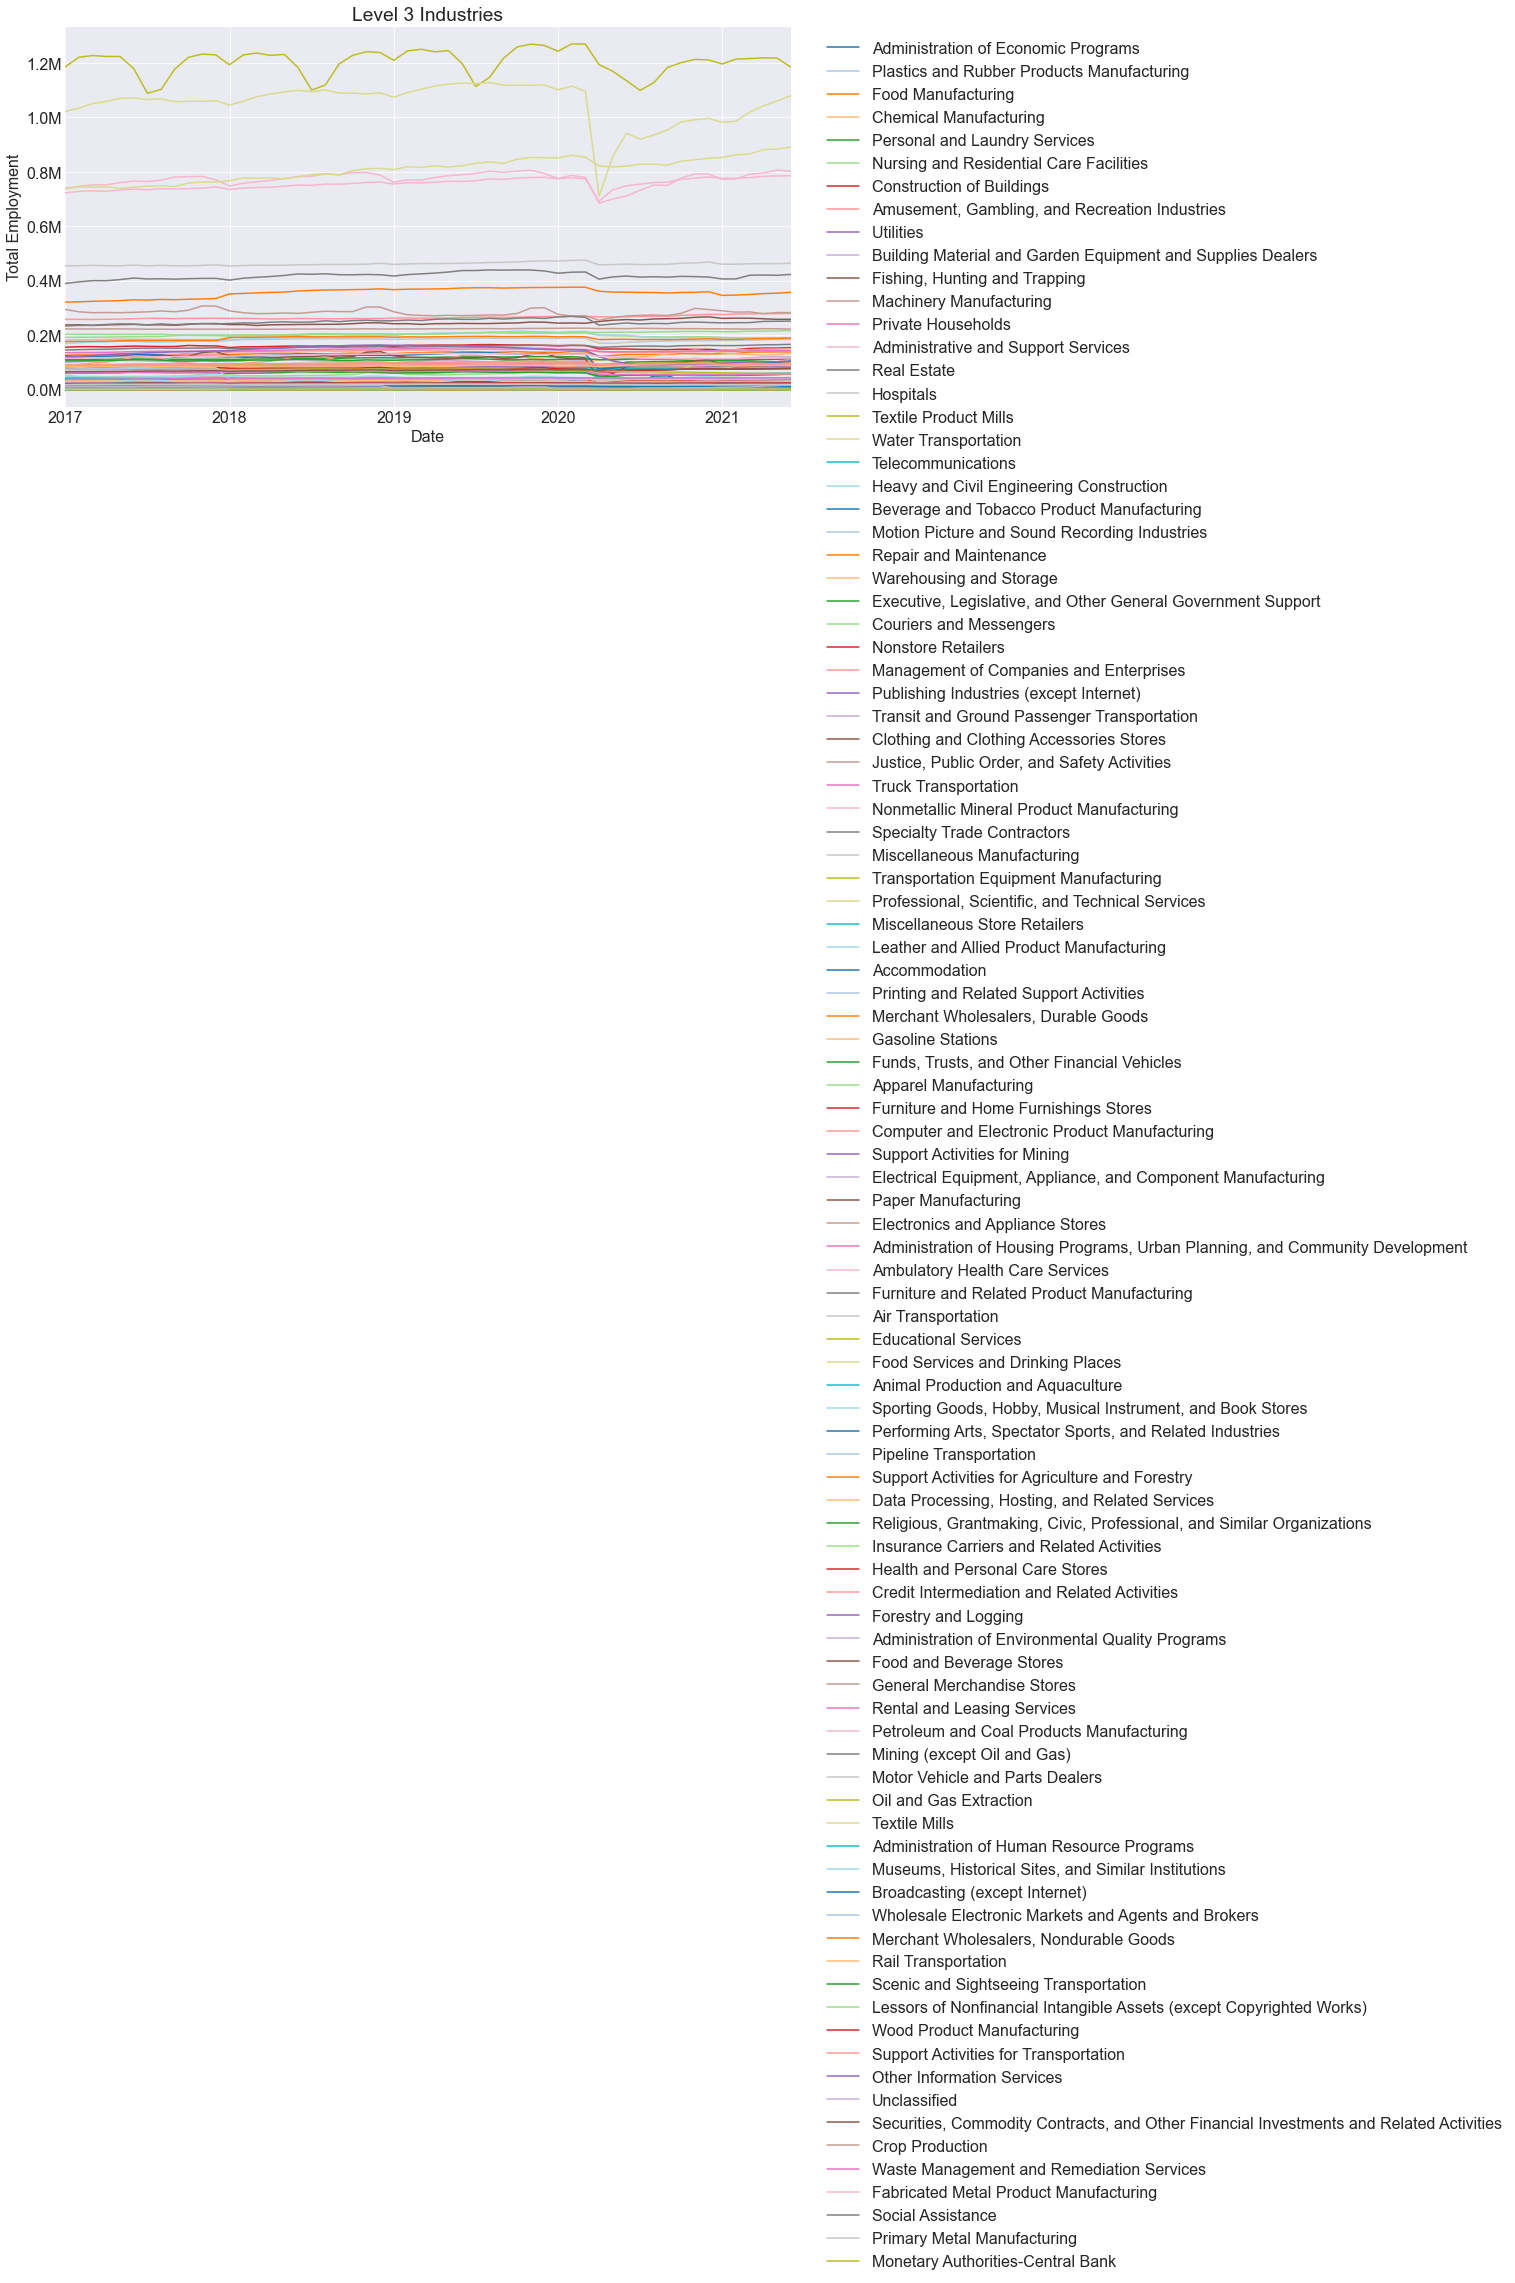

In [351]:
# plot for all industries
ind_list = df.Industry.value_counts().index.tolist()
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind]
for ind in ind_list:
    industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 3 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

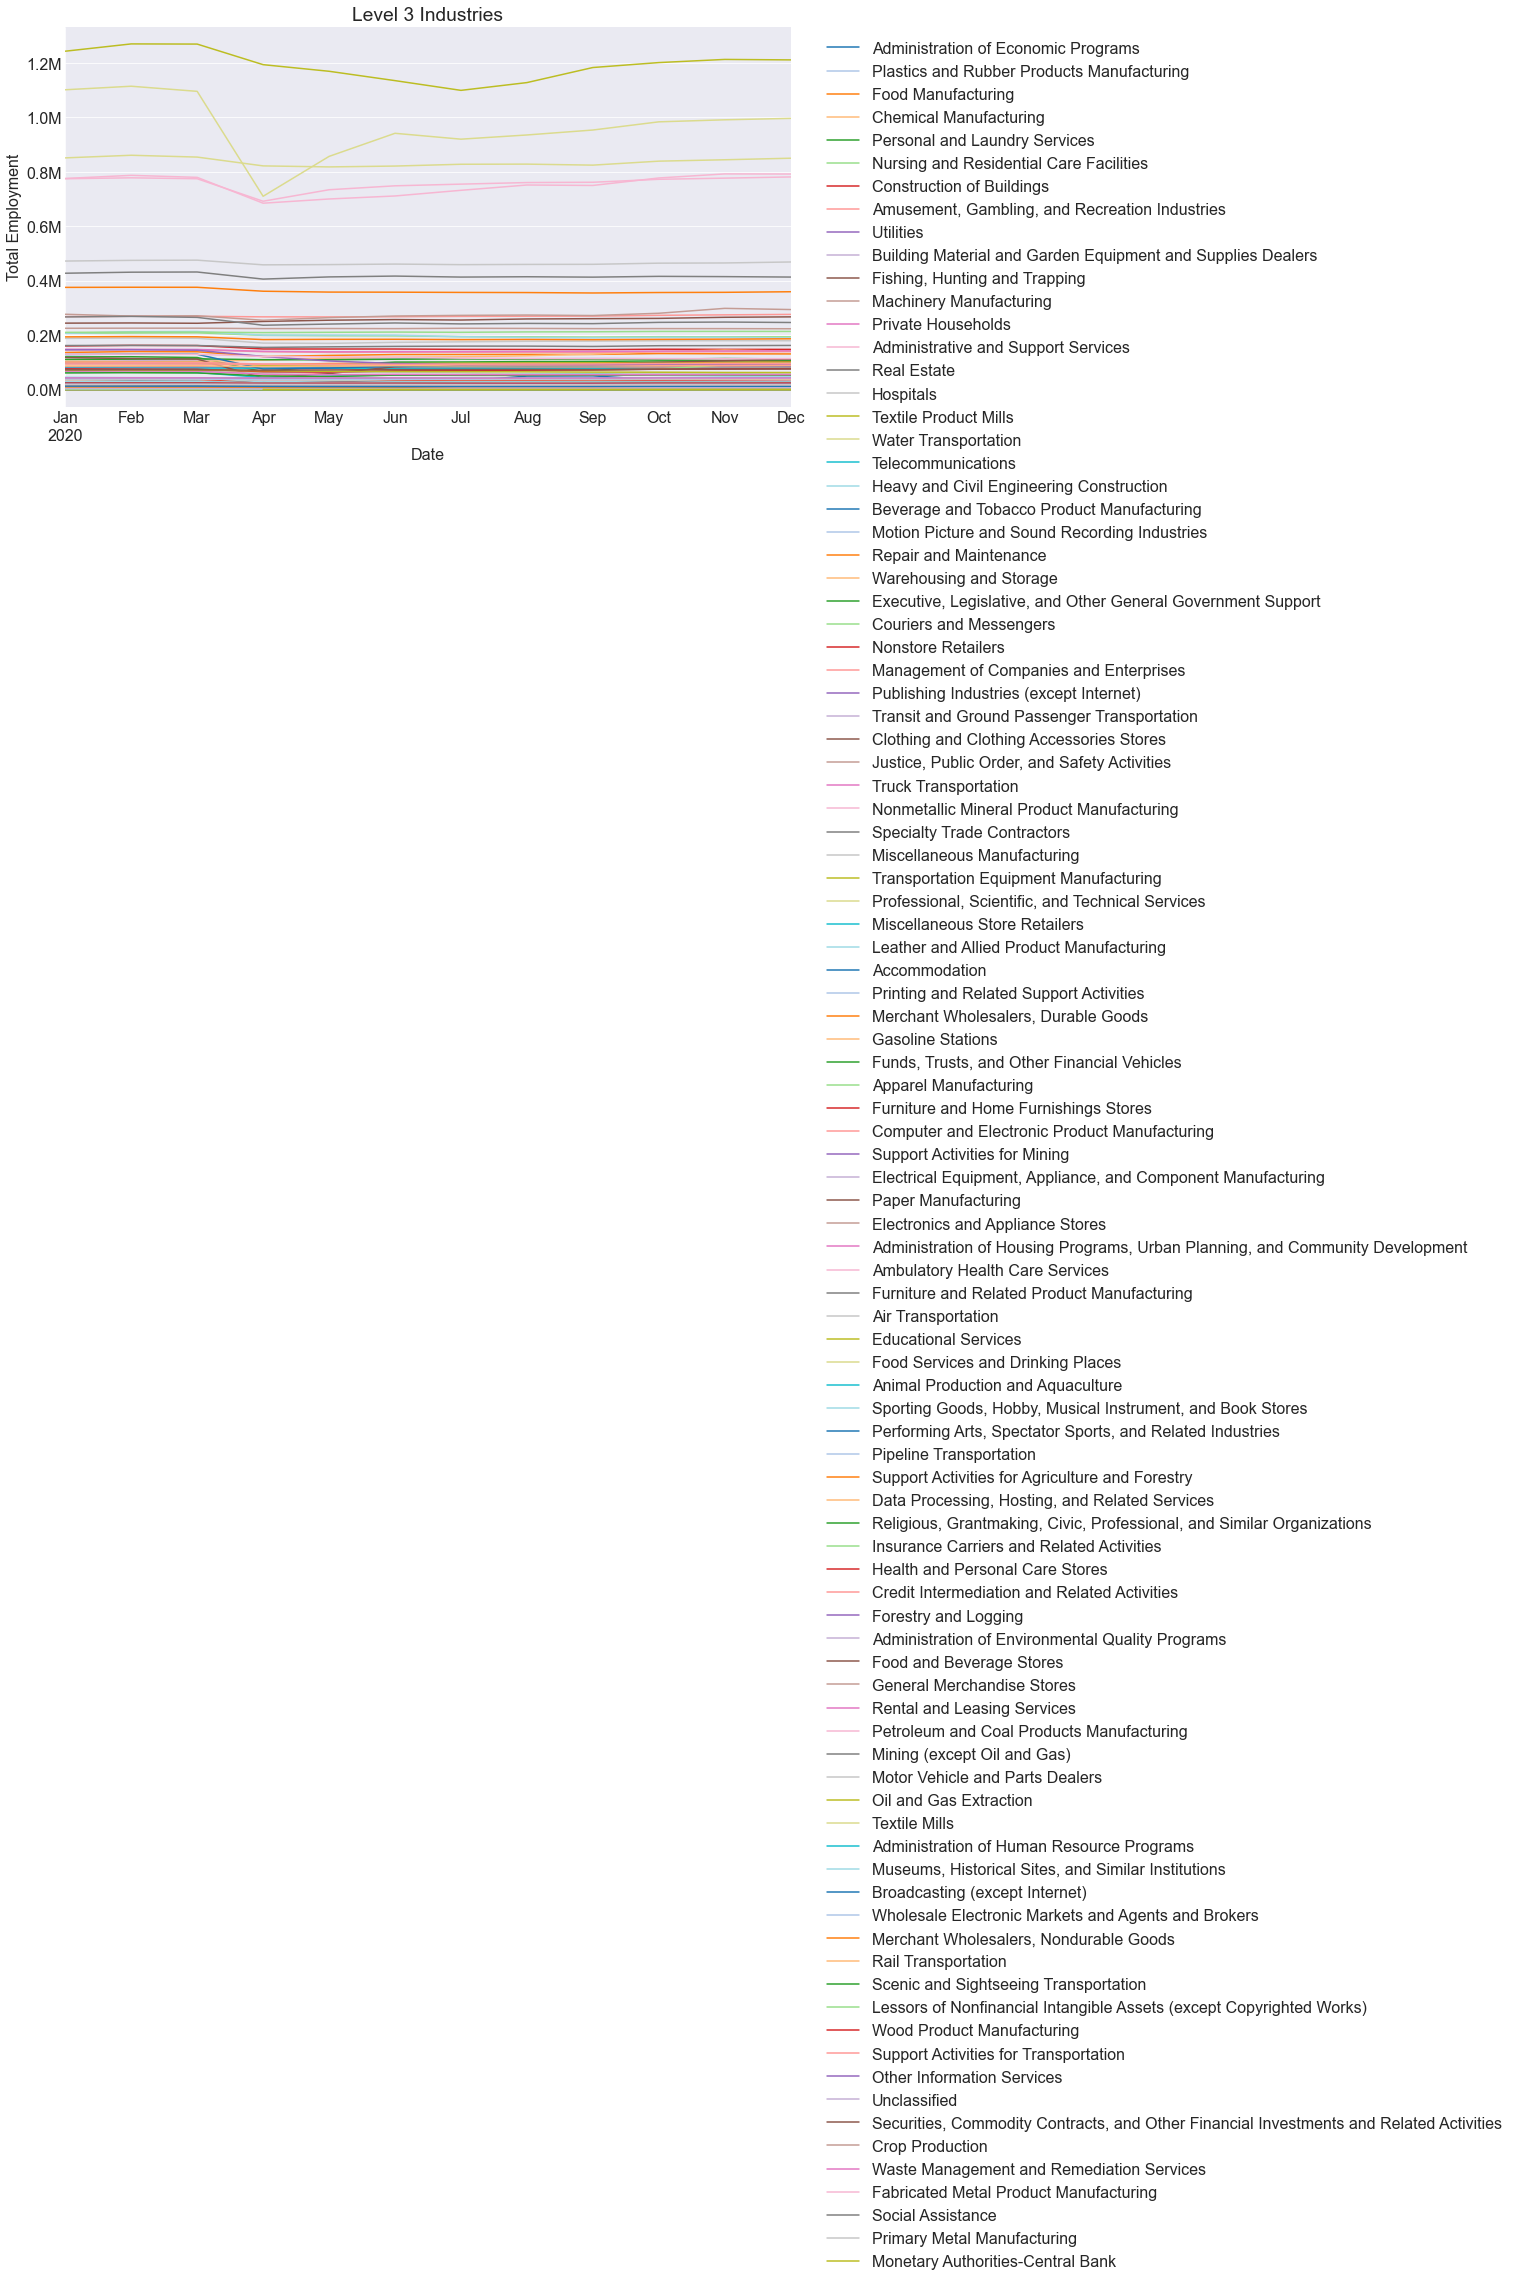

In [352]:
# plot for all industries 2020
ind_list = df.Industry.value_counts().index.tolist()
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind]
for ind in ind_list:
    industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment']['2020'].sort_index().plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 3 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

In [366]:
# create a dictionary with all dfs for each industry for year 2020
ind_list = df.Industry.value_counts().index.tolist()
ind_list[-1]

'Monetary Authorities-Central Bank'

In [367]:
ind_list.pop(-1)

'Monetary Authorities-Central Bank'

In [369]:
len(ind_list)

96

In [370]:
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index()['2020']

In [371]:
industry_df_dict['Plastics and Rubber Products Manufacturing']

Date
2020-01-01    41576
2020-02-01    41694
2020-03-01    41663
2020-04-01    39774
2020-05-01    39098
2020-06-01    39448
2020-07-01    39605
2020-08-01    39508
2020-09-01    39591
2020-10-01    39712
2020-11-01    40020
2020-12-01    40227
Name: Total Employment, dtype: int64

In [372]:
apr = industry_df_dict['Plastics and Rubber Products Manufacturing']['2020-04'][0]

In [373]:
mar = industry_df_dict['Plastics and Rubber Products Manufacturing']['2020-03'][0]

In [374]:
(apr / mar) * 100

95.46600100808871

In [375]:
len(industry_df_dict)

96

In [406]:
industry_df_dict['Plastics and Rubber Products Manufacturing'].std()

938.2133245825505

Need to figure out how to create a new df with rows for each industry (97) and columns for each statistical characteristic

In [416]:
# write a function that takes in a series and returns a dictionary with all the characteristic values with associated keys (column names)
def characterize_series(series):
    pcnt_decrease = ((s['2020-03'][0] - s['2020-04'][0]) / s['2020-03'][0]) * 100
    recovery_slope = (s['2020-06'][0] - s['2020-04'][0]) / 2 # need to normalize this?
    mean = s.mean()
    std = s.std()
    rec_slope_norm = recovery_slope / mean
    cov = mean / std
    characteristic_dict = {
        'pcnt_decrease' : pcnt_decrease,
        'recovery_slope' : recovery_slope,
        'mean' : mean,
        'standard_dev' : std,
        'recovery_slope_normalized' : rec_slope_norm,
        'cov' : cov
    }
    return characteristic_dict

In [417]:
# create an empty characteristics list (list of dictionaries to convert to df)
characteristics = []

In [418]:
# Use dictionary comprehension that runs through each entry in industry_df_dict and appends dictionary to char list (or for loop)
for ind in ind_list:
    s = industry_df_dict[ind]
    characteristics.append(characterize_series(s))
    #print(len(s))

In [419]:
# convert characteristics list into df
char_df = pd.DataFrame(characteristics, index=ind_list)
char_df.sort_values(by='recovery_slope', ascending=False).head(10)

pcnt_decrease  recovery_slope  \
Food Services and Drinking Places                   35.153593        115628.5   
Ambulatory Health Care Services                     10.652583         28298.5   
Amusement, Gambling, and Recreation Industries      53.675816         21461.0   
Clothing and Clothing Accessories Stores            61.838901         20903.5   
Personal and Laundry Services                       44.098161         17764.5   
Administrative and Support Services                 12.162763         13265.5   
General Merchandise Stores                           6.061442          7813.0   
Specialty Trade Contractors                          6.026689          5548.0   
Accommodation                                       41.579068          5248.0   
Warehousing and Storage                             -5.055032          5156.0   

                                                         mean   standard_dev  \
Food Services and Drinking Places               967051.333333  112858.674168   
Ambulatory Health Care Services                 759623.083333   25355.354595   
Amusement, Gambling, and Recreation Industries   88296.666667   16900.121013   
Clothing and Clothing Accessories Stores         94593.750000   22972.835817   
Personal and Laundry Services                   104200.333333   15002.558590   
Administrative and Support Services             753337.916667   37724.281157   
General Merchandise Stores                      275678.666667   11848.367278   
Specialty Trade Contractors                     418456.250000    8067.965860   
Accommodation                                    97462.250000   20413.273125   
Warehousing and Storage                         122100.500000   15390.172753   

                                                recovery_slope_normalized  \
Food Services and Drinking Places                                0.119568   
Ambulatory Health Care Services                                  0.037253   
Amusement, Gambling, and Recreation Industries                   0.243056   
Clothing and Clothing Accessories Stores                         0.220982   
Personal and Laundry Services                                    0.170484   
Administrative and Support Services                              0.017609   
General Merchandise Stores                                       0.028341   
Specialty Trade Contractors                                      0.013258   
Accommodation                                                    0.053846   
Warehousing and Storage                                          0.042228   

                                                      cov  
Food Services and Drinking Places                8.568693  
Ambulatory Health Care Services                 29.959079  
Amusement, Gambling, and Recreation Industries   5.224617  
Clothing and Clothing Accessories Stores         4.117635  
Personal and Laundry Services                    6.945504  
Administrative and Support Services             19.969576  
General Merchandise Stores                      23.267228  
Specialty Trade Contractors                     51.866388  
Accommodation                                    4.774455  
Warehousing and Storage                          7.933667

In [420]:
char_df.shape

(96, 6)

---
## Different ways to customize colors of lines
---

In [40]:
# check matplotlib version
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.3.4


In [41]:
# get a cmap and pull out colors from it to save to a list and use with cycler
cmap = matplotlib.cm.get_cmap('gist_rainbow')
cmap

In [42]:
# check number of lines needed here
len(ind_list)

1

In [43]:
# get list of colors
colors = [cmap(i) for i in np.linspace(0, 1, 12)]

In [44]:
# use cm.rainbow to generate another list of colors
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 12))

In [45]:
# # do the same thing for wages
# from cycler import cycler


# plt.gca().set_prop_cycle(cycler('color', colors))
# for ind in ind_list:
#     df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
# plt.gca().set(ylabel = 'Total Employment', title='Level 1 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}M'.format(x / 1_000_000))
# plt.legend(bbox_to_anchor= (1.03,1));